In [1]:
!pip install pandas==2.2.3 numpy==2.2.4 matplotlib==3.10.1 pyarrow==19.0.1 scikit-learn==1.6.1 tkan==0.4.3 temporal_linear_network==0.1.2 scipy==1.15.2 seaborn==0.13.2 "jax[cuda12]==0.5.2" opt_einsum==3.4.0 jaxlib==0.5.1 ml_dtypes==0.5.1 "jax-cuda12-plugin[with_cuda]==0.5.1" tzdata==2025.2 python-dateutil==2.9.0.post0 pytz==2025.2 packaging==24.2 contourpy==1.3.1 cycler==0.12.1 fonttools==4.56.0 pillow==11.1.0 pyparsing==2.4.7 kiwisolver==1.4.8 threadpoolctl==3.6.0 joblib==1.4.2 keras_efficient_kan==0.1.10 keras==3.9.0 jax-cuda12-pjrt==0.5.1 nvidia-cuda-cupti-cu12==12.8.90 nvidia-cuda-nvcc-cu12==12.8.93 nvidia-cusolver-cu12==11.7.3.90 nvidia-cuda-runtime-cu12==12.8.90 nvidia-cufft-cu12==11.3.3.83 nvidia-cusparse-cu12==12.5.8.93 nvidia-cublas-cu12==12.8.4.1 nvidia-nvjitlink-cu12==12.8.93 nvidia-cudnn-cu12==9.8.0.87 nvidia-nccl-cu12==2.26.2 absl-py==2.2.0 optree==0.14.1 h5py==3.13.0 rich==13.9.4 namex==0.0.8 six==1.16.0 typing-extensions==4.12.2 markdown-it-py==3.0.0 pygments==2.19.1 mdurl==0.1.2

In [2]:
import os
import time
import itertools

BACKEND = 'jax'  # You can use any backend here
os.environ['KERAS_BACKEND'] = BACKEND
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = ".99"
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import ops

from lems.loss import lem_loss
from lems.metrics import (
    buy_vwap_avg_imp,
    buy_twap_avg_imp,
    sell_vwap_avg_imp,
    sell_twap_avg_imp,
    buy_vwap_avg_risk,
    buy_twap_avg_risk,
    sell_vwap_avg_risk,
    sell_twap_avg_risk,
    unsigned_vwap_avg_risk,
    unsigned_twap_avg_risk
)
from lems.data_formater import prepare_data_with_ahead_inputs, add_config_to_X, add_config_to_y
from lems.models import LargeExecutionModel

keras.utils.set_random_seed(42) 

early_stopping_callback = lambda : keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=2,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=0,
)
lr_callback = lambda : keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=1,
    mode="min",
    min_delta=0.00001,
    min_lr=0.000025,
    verbose=0,
)
callbacks = lambda : [early_stopping_callback(), lr_callback(), keras.callbacks.TerminateOnNaN()]

N_MAX_EPOCHS = 1000
N_RUNS = 1

NOTIONAL_PARQUET_PATH = "daily_dow_fake_notionals.parquet"
VOLUME_PARQUET_PATH = "daily_dow_volumes.parquet"

N_ASSETS = 30

volumes = pd.read_parquet(VOLUME_PARQUET_PATH).astype(np.float32)
sorted_assets = list((volumes.fillna(0)==0).sum(axis=0).sort_values(ascending=True).index)
if N_ASSETS is not None:
    sorted_assets=sorted_assets[:N_ASSETS]
train_assets = sorted_assets
all_assets = sorted_assets

print('training on', train_assets)
print()
print('testing on', all_assets)

training on ['AMZN', 'CVX', 'UNH', 'AMGN', 'VZ', 'AAPL', 'AXP', 'GS', 'SHW', 'JNJ', 'MCD', 'CSCO', 'IBM', 'WMT', 'PG', 'NKE', 'TRV', 'HON', 'MMM', 'MSFT', 'JPM', 'HD', 'KO', 'DIS', 'BA', 'CAT', 'NVDA', 'MRK', 'CRM', 'V']

testing on ['AMZN', 'CVX', 'UNH', 'AMGN', 'VZ', 'AAPL', 'AXP', 'GS', 'SHW', 'JNJ', 'MCD', 'CSCO', 'IBM', 'WMT', 'PG', 'NKE', 'TRV', 'HON', 'MMM', 'MSFT', 'JPM', 'HD', 'KO', 'DIS', 'BA', 'CAT', 'NVDA', 'MRK', 'CRM', 'V']


In [3]:
def full_generate(target_asset, lookback=120, n_ahead=12, split_date=None, autoscale_target=True, include_ahead_inputs=False):
    volumes = pd.read_parquet(VOLUME_PARQUET_PATH).astype(np.float32)
    notionals = pd.read_parquet(NOTIONAL_PARQUET_PATH).astype(np.float32)
    assets = [target_asset]
    
    assert target_asset in assets
    volumes = volumes[assets].dropna()
    notionals = notionals[assets].dropna()
    notionals = notionals.loc[volumes.index]
    volumes = volumes.loc[notionals.index]
    vwaps = pd.DataFrame(notionals.values / volumes.values, index=volumes.index, columns=volumes.columns)
    vwaps = vwaps.ffill().dropna()
    notionals = notionals.loc[vwaps.index]
    volumes = volumes.loc[vwaps.index]
    
    # Create features
    features = volumes / volumes.shift(lookback + n_ahead).rolling(24 * 7 * 2).mean()
    features['month'] = volumes.index.month
    features['dow'] = volumes.index.dayofweek
    for asset in assets:
        features[f'returns {asset}'] = vwaps[asset] / vwaps[asset].shift() - 1.
    
    # Select the target series and align
    volumes_series = volumes[target_asset]
    vwaps_series = vwaps[target_asset]
    features = features.loc[volumes_series.index].dropna()
    volumes_series = volumes_series.loc[features.index]
    vwaps_series = vwaps_series.ffill().loc[volumes_series.index]
    features['prices'] = vwaps_series.values
    features['volumes'] = volumes_series.values

    # Build samples and also capture their associated dates (forecast origin)
    if include_ahead_inputs:
        X, y, sample_dates = prepare_data_with_ahead_inputs(
            vwaps_series.values, volumes_series.values, features.values, features.index, lookback, n_ahead, autoscale_target=autoscale_target
        )
    else:
        # (Assume prepare_data_without_ahead_inputs is modified similarly to return sample_dates)
        X, y, sample_dates = prepare_data_without_ahead_inputs(
            vwaps_series.values, volumes_series.values, features.values, features.index, lookback, n_ahead, autoscale_target=autoscale_target
        )
    
    # If a split_date is provided, use it to separate train and test samples
    if split_date is not None:
        split_date = pd.to_datetime(split_date, utc=True)
        mask_train = sample_dates < split_date
        mask_test = sample_dates >= split_date
        X_train = X[mask_train]
        y_train = y[mask_train]
        X_test = X[mask_test]
        y_test = y[mask_test]
        return X_train, X_test, y_train, y_test, sample_dates
    else:
        # Fall back to size-based split if no date is provided
        test_row = int(len(y) * 0.2)
        X_train = X[:-test_row]
        X_test = X[-test_row:]
        y_train = y[:-test_row]
        y_test = y[-test_row:]
        return X_train, X_test, y_train, y_test, sample_dates

In [4]:
def create_mask(batch, n_ahead):
    base_mask = ops.tile(ops.transpose(ops.tril(ops.ones((n_ahead, n_ahead)), k=0))[None,:,:,None,None], (batch, 1, 1, 4, 2))
    return ops.concatenate([base_mask, ops.ones((batch, n_ahead, 1, 4, 2))], axis = 2)

def preds_to_graph(model, augmented_X, augmented_y, graph_name="test"):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    import keras  # assuming keras is imported properly elsewhere
    # --- Your prediction and plotting of execution curves as before ---
    preds = model.predict(augmented_X, batch_size=BATCH_SIZE, verbose=False) # (bach
    
    y_true, y_pred = augmented_y, preds
    y_pred_twap = np.array(y_pred)
    y_pred_twap[:,:,:] = 1/n_ahead
    
    mkt_volumes = y_true[...,0:1] 
    mkt_prices = y_true[...,1:2]
    # External (forced) mask (assumed provided as 0/1) - represent minimum execution time
    mask = ops.cast(create_mask(y_pred.shape[0], y_pred.shape[1]), dtype=y_true.dtype)

    mkt_minimum_trade_mask = ops.tile(
        ops.concatenate(
            [
                ops.ones((ops.shape(mkt_volumes)[0], 1, ops.shape(mkt_volumes)[2], 4, 1)),
                1. - ops.cast(keras.ops.cumsum(mkt_volumes, axis=1) > 0., dtype=y_true.dtype)[:,:-1]
            ], axis=1
        ), (1, 1, 1, 1, 2)
    )
    needed_execution_mask = (
        mask 
        + (1 - mask)
        * mkt_minimum_trade_mask
    )
    # Compute soft masks for all channel using cumulative sum 
    effective_execution_mask = (
        needed_execution_mask
        + (1 - needed_execution_mask)
        * ops.cast(ops.flip(keras.ops.cumsum(ops.flip(y_pred, axis=1), axis=1), axis=1) > 0., dtype=y_true.dtype)
    )
    
    eps = keras.backend.epsilon()
    
    # Volume Section:
    executed_volumes = y_pred[...,0:1] * effective_execution_mask[...,0:1]
    executed_notionals = executed_volumes * mkt_prices
    price_achieved_vto = ops.sum(executed_notionals, axis=1) / (ops.sum(executed_volumes, axis=1) + eps)
    
    # Notional Section:
    executed_notionals = y_pred[...,1:2] * effective_execution_mask[...,1:2]
    executed_volumes = executed_notionals / mkt_prices
    price_achieved_nto = ops.sum(executed_notionals, axis=1) / (ops.sum(executed_volumes, axis=1) + eps)
    
    price_achieved = ops.concatenate([price_achieved_vto, price_achieved_nto], axis=3)
    
    mkt_achieved_volumes = mkt_volumes * effective_execution_mask
    mkt_achieved_notionals = mkt_achieved_volumes * mkt_prices
    mkt_benchmarks = ops.sum(mkt_achieved_notionals, axis=1) / (ops.sum(mkt_achieved_volumes, axis=1) + eps)
    
    diffs = (price_achieved / mkt_benchmarks - 1.) 
    
    vwap_mkt = keras.ops.sum(mkt_volumes[:,:,0,0] * mkt_prices[:,:,0,0], axis=1) / \
               keras.ops.sum(mkt_volumes[:,:,0,0], axis=1)
    
    twap_volume = keras.ops.sum(mkt_prices[:,:,0,0], axis=1) / y_true.shape[1]
    vwap_diff_twap_volume = (twap_volume / vwap_mkt - 1.)
    
    buy_twap_vol =  1. / y_true.shape[1] / mkt_prices[:,:,0,0]
    twap_notional = 1. / (keras.ops.sum(buy_twap_vol, axis=1) + eps)
    vwap_diff_twap_notional = (twap_notional / vwap_mkt - 1.)
    for min_period in range(diffs.shape[1]):
        print(f'result using min_period={min_period}')
        titles = [
            'execution curve BUY VWAP',
            'execution curve BUY TWAP',
            'execution curve SELL VWAP',
            'execution curve SELL TWAP',
        ]
        
        # Create a 2x2 grid of subplots
        fig, axs = plt.subplots(4, 2, figsize=(12, 10))
        
        # Loop through each subplot, using the same color, thin lines, and transparency
        for order_type in range(4):
            for target in range(2):
                ax = axs[order_type, target]
                curves = np.cumsum(preds[::100, :, min_period, order_type, target], axis=1).T
                ax.plot(curves, color='blue', lw=0.5, alpha=0.1)
                ax.set_title(f"{titles[order_type]} {'Volume' if target==0 else 'Notional'}")
        
        # --- Convert each difference tensor to a 1D numpy array ---
        data_twap_notional = np.array(vwap_diff_twap_notional)[:, 0]
        data_twap_volume   = np.array(vwap_diff_twap_volume)[:, 0]
        data_buy_volume    = diffs[:, min_period, 0, 0]
        data_sell_volume   = diffs[:, min_period, 2, 0]
        data_buy_notional  = diffs[:, min_period, 0, 1]
        data_sell_notional = diffs[:, min_period, 2, 1]
        
        data_buy_volume_twap = diffs[:, min_period, 1, 0]
        data_sell_volume_twap   = diffs[:, min_period, 3, 0]
        data_buy_notional_twap  = diffs[:, min_period, 1, 1]
        data_sell_notional_twap = diffs[:, min_period, 3, 1]
        
        # --- Define plotting parameters and colors ---
        bins = 50
        alpha_hist = 0.3
        
        # Compute global percentile limits for all data at once:
        all_data = np.concatenate([
            data_twap_notional, data_twap_volume,
            data_buy_volume, data_sell_volume,
            data_buy_notional, data_sell_notional,
            data_buy_volume_twap, data_sell_volume_twap,
            data_buy_notional_twap, data_sell_notional_twap
        ])
        
        x_min_global = np.percentile(all_data, 1)
        x_max_global = np.percentile(all_data, 99)
        
        # Define common x-range and bins for histograms within this clipped region
        x_range_global = np.linspace(x_min_global, x_max_global, 200)
        bins_global = np.linspace(x_min_global, x_max_global, bins)
        
        # Now use these global limits for each subplot:
        fig, axs = plt.subplots(4, 2, figsize=(15, 18))
        
        subplot_configs = [
            ([data_twap_notional, data_twap_volume],
             ['purple', 'orange'],
             ['TWAP Notional', 'TWAP Volume'],
             "TWAP Notional vs TWAP Volume\nImpact of buying notional instead of quantity",
             axs[0, 0]),
        
            ([data_buy_volume, data_sell_volume, data_buy_notional, data_sell_notional],
             ['navy', 'crimson', 'deepskyblue', 'coral'],
             ['VWAP Buy Volume', 'VWAP Sell Volume', 'VWAP Buy Notional', 'VWAP Sell Notional'],
             "VWAP Volume & Notional Differences\nCombined view of VWAP buy/sell volume and notional",
             axs[0, 1]),
        
            ([data_twap_volume, data_buy_volume],
             ['forestgreen', 'dodgerblue'],
             ['TWAP Volume', 'VWAP Buy Volume'],
             "TWAP Volume vs VWAP Buy Volume\nComparison of TWAP volume and VWAP buy volume",
             axs[1, 0]),
        
            ([data_twap_volume, data_sell_volume],
             ['forestgreen', 'indianred'],
             ['TWAP Volume', 'VWAP Sell Volume'],
             "TWAP Volume vs VWAP Sell Volume\nComparison of TWAP volume and VWAP sell volume",
             axs[1, 1]),
        
            ([data_twap_notional, data_buy_notional],
             ['seagreen', 'skyblue'],
             ['TWAP Notional', 'VWAP Buy Notional'],
             "TWAP Notional vs VWAP Buy Notional\nComparison of TWAP notional and VWAP buy notional",
             axs[2, 0]),
        
            ([data_twap_notional, data_sell_notional],
             ['seagreen', 'salmon'],
             ['TWAP Notional', 'VWAP Sell Notional'],
             "TWAP Notional vs VWAP Sell Notional\nComparison of TWAP notional and VWAP sell notional",
             axs[2, 1]),
        
            ([data_buy_volume_twap, data_sell_volume_twap],
             ['seagreen', 'skyblue'],
             ['TWAP Buy Volume', 'TWAP Sell Volume'],
             "TWAP Buy vs TWAP Sell\nComparison of TWAP strategies with Volume objective",
             axs[3, 0]),
        
            ([data_buy_notional_twap, data_sell_notional_twap],
             ['seagreen', 'salmon'],
             ['TWAP Buy Notional', 'TWAP Sell Notional'],
             "TWAP Buy vs TWAP Sell\nComparison of TWAP strategies with Notional objective",
             axs[3, 1]),
        ]
        
        for data_list, colors, names, title, ax in subplot_configs:
            for data, color, name in zip(data_list, colors, names):
                # Compute mean/std on original unfiltered data
                mean_val, std_val = np.mean(data), np.std(data)
        
                # Filter data strictly for histogram visualization
                data_filtered = data[(data >= x_min_global) & (data <= x_max_global)]
                
                ax.hist(data_filtered, bins=bins_global, alpha=alpha_hist, density=True, color=color,
                        label=f'{name} (mean={mean_val*10000:.2f}bps, std={std_val*10000:.2f}bps)')
                
                # Use filtered data for KDE as well:
                if len(data_filtered) > 1:  # check to avoid KDE issues
                    density = gaussian_kde(data_filtered)
                    ax.plot(x_range_global, density(x_range_global), color=color, lw=3)
                
                # Plot vertical line at the original data's mean
                ax.axvline(mean_val, color=color, linestyle='--', lw=2)
        
            ax.set_xlim(x_min_global, x_max_global)
            ax.set_xlabel('Difference')
            ax.set_ylabel('Density')
            ax.set_title(title)
            ax.legend()
        
        plt.tight_layout()
        plt.savefig(f'{graph_name}_{name}_performance_curves_min_period_{min_period}.jpeg')
        plt.show()

def simple_pred_plot(preds, max_row = 20):
    for sample in range(preds.shape[0]):
        for minimum_period in range(preds.shape[2]):
            print('minimum period=', minimum_period)
            plt.plot(np.cumsum(preds[sample, :, minimum_period, 0, 0]), label='buy vwap volume')
            plt.plot(np.cumsum(preds[sample, :, minimum_period, 1, 0]), label='buy twap volume')
            plt.plot(np.cumsum(preds[sample, :, minimum_period, 2, 0]), label='sell vwap volume')
            plt.plot(np.cumsum(preds[sample, :, minimum_period, 3, 0]), label='sell twap volume')
            plt.plot(np.cumsum(preds[sample, :, minimum_period, 0, 1]), label='buy vwap notional')
            plt.plot(np.cumsum(preds[sample, :, minimum_period, 1, 1]), label='buy twap notional')
            plt.plot(np.cumsum(preds[sample, :, minimum_period, 2, 1]), label='sell vwap notional')
            plt.plot(np.cumsum(preds[sample, :, minimum_period, 3, 1]), label='sell twap notional')
            plt.legend()
            plt.show()
        if sample > max_row:
            break


In [5]:
import pandas as pd
import numpy as np

def calculate_statistics(data):
    """Calculate comprehensive statistics for given data"""
    data_array = np.array(data) * 10000  # Convert to basis points
    return {
        'Mean (bps)': np.mean(data_array),
        'Std (bps)': np.std(data_array),
        'Median (bps)': np.median(data_array),
        'P5 (bps)': np.percentile(data_array, 5),
        'P95 (bps)': np.percentile(data_array, 95),
        'Q25 (bps)': np.percentile(data_array, 25),
        'Q75 (bps)': np.percentile(data_array, 75)
    }

def create_tables_from_predictions(model, augmented_X, augmented_y, name="test"):
    import keras
    from keras import ops
    
    # Get predictions and compute differences (same as original function)
    preds = model.predict(augmented_X, batch_size=256, verbose=False)
    
    y_true, y_pred = augmented_y, preds
    n_ahead = y_pred.shape[1]
    
    mkt_volumes = y_true[...,0:1] 
    mkt_prices = y_true[...,1:2]
    mask = ops.cast(create_mask(y_pred.shape[0], y_pred.shape[1]), dtype=y_true.dtype)

    mkt_minimum_trade_mask = ops.tile(
        ops.concatenate(
            [
                ops.ones((ops.shape(mkt_volumes)[0], 1, ops.shape(mkt_volumes)[2], 4, 1)),
                1. - ops.cast(keras.ops.cumsum(mkt_volumes, axis=1) > 0., dtype=y_true.dtype)[:,:-1]
            ], axis=1
        ), (1, 1, 1, 1, 2)
    )
    needed_execution_mask = (
        mask 
        + (1 - mask)
        * mkt_minimum_trade_mask
    )
    effective_execution_mask = (
        needed_execution_mask
        + (1 - needed_execution_mask)
        * ops.cast(ops.flip(keras.ops.cumsum(ops.flip(y_pred, axis=1), axis=1), axis=1) > 0., dtype=y_true.dtype)
    )
    
    eps = keras.backend.epsilon()
    
    # Volume Section:
    executed_volumes = y_pred[...,0:1] * effective_execution_mask[...,0:1]
    executed_notionals = executed_volumes * mkt_prices
    price_achieved_vto = ops.sum(executed_notionals, axis=1) / (ops.sum(executed_volumes, axis=1) + eps)
    
    # Notional Section:
    executed_notionals = y_pred[...,1:2] * effective_execution_mask[...,1:2]
    executed_volumes = executed_notionals / mkt_prices
    price_achieved_nto = ops.sum(executed_notionals, axis=1) / (ops.sum(executed_volumes, axis=1) + eps)
    
    price_achieved = ops.concatenate([price_achieved_vto, price_achieved_nto], axis=3)
    
    mkt_achieved_volumes = mkt_volumes * effective_execution_mask
    mkt_achieved_notionals = mkt_achieved_volumes * mkt_prices
    mkt_benchmarks = ops.sum(mkt_achieved_notionals, axis=1) / (ops.sum(mkt_achieved_volumes, axis=1) + eps)
    
    diffs = (price_achieved / mkt_benchmarks - 1.) 
    
    vwap_mkt = keras.ops.sum(mkt_volumes[:,:,0,0] * mkt_prices[:,:,0,0], axis=1) / \
               keras.ops.sum(mkt_volumes[:,:,0,0], axis=1)
    
    twap_volume = keras.ops.sum(mkt_prices[:,:,0,0], axis=1) / y_true.shape[1]
    vwap_diff_twap_volume = (twap_volume / vwap_mkt - 1.)
    
    buy_twap_vol = 1. / y_true.shape[1] / mkt_prices[:,:,0,0]
    twap_notional = 1. / (keras.ops.sum(buy_twap_vol, axis=1) + eps)
    vwap_diff_twap_notional = (twap_notional / vwap_mkt - 1.)
    
    # Create Table 1: TWAP deviations and VWAP model performance by minimum period
    table1_data = []
    
    # TWAP Benchmarks block
    table1_data.append(['TWAP Notional', 'All'] + list(calculate_statistics(vwap_diff_twap_notional).values()))
    table1_data.append(['TWAP Volume', 'All'] + list(calculate_statistics(vwap_diff_twap_volume).values()))
    
    # BUY block - VWAP model performance for each minimum period
    for min_period in range(n_ahead+1):
        table1_data.append(['BUY', min_period] + 
                          list(calculate_statistics(diffs[:, min_period, 0, 0]).values()))
    
    # SELL block - VWAP model performance for each minimum period  
    for min_period in range(n_ahead+1):
        table1_data.append(['SELL', min_period] + 
                          list(calculate_statistics(diffs[:, min_period, 2, 0]).values()))
    
    columns1 = ['Order Type', 'Min Period', 'Mean (bps)', 'Std (bps)', 'Median (bps)', 
                'P5 (bps)', 'P95 (bps)', 'Q25 (bps)', 'Q75 (bps)']
    table1 = pd.DataFrame(table1_data, columns=columns1)
    table1 = table1.set_index(['Order Type', 'Min Period'])
    
    # Create Table 2: Detailed model comparison for minimum period 6
    min_period = 6
    table2_data = []
    
    # BUY strategies - TWAP first, then VWAP
    table2_data.append(['BUY', 'TWAP Volume vs TWAP'] + 
                      list(calculate_statistics(diffs[:, min_period, 1, 0]).values()))
    table2_data.append(['BUY', 'TWAP Notional vs TWAP'] + 
                      list(calculate_statistics(diffs[:, min_period, 1, 1]).values()))
    table2_data.append(['BUY', 'VWAP Volume vs VWAP'] + 
                      list(calculate_statistics(diffs[:, min_period, 0, 0]).values()))
    table2_data.append(['BUY', 'VWAP Notional vs VWAP'] + 
                      list(calculate_statistics(diffs[:, min_period, 0, 1]).values()))
    
    # SELL strategies - TWAP first, then VWAP
    table2_data.append(['SELL', 'TWAP Volume vs TWAP'] + 
                      list(calculate_statistics(diffs[:, min_period, 3, 0]).values()))
    table2_data.append(['SELL', 'TWAP Notional vs TWAP'] + 
                      list(calculate_statistics(diffs[:, min_period, 3, 1]).values()))
    table2_data.append(['SELL', 'VWAP Volume vs VWAP'] + 
                      list(calculate_statistics(diffs[:, min_period, 2, 0]).values()))
    table2_data.append(['SELL', 'VWAP Notional vs VWAP'] + 
                      list(calculate_statistics(diffs[:, min_period, 2, 1]).values()))
    
    columns2 = ['Order Type', 'Strategy', 'Mean (bps)', 'Std (bps)', 'Median (bps)', 
                'P5 (bps)', 'P95 (bps)', 'Q25 (bps)', 'Q75 (bps)']
    table2 = pd.DataFrame(table2_data, columns=columns2)
    table2 = table2.set_index(['Order Type', 'Strategy'])
    
    # Create additional tables for minimum periods 9, 11, 12
    additional_tables = {}
    for min_period in [9, 11, 12]:
        table_data = []
        
        # BUY strategies - TWAP first, then VWAP
        table_data.append(['BUY', 'TWAP Volume vs TWAP'] + 
                          list(calculate_statistics(diffs[:, min_period, 1, 0]).values()))
        table_data.append(['BUY', 'TWAP Notional vs TWAP'] + 
                          list(calculate_statistics(diffs[:, min_period, 1, 1]).values()))
        table_data.append(['BUY', 'VWAP Volume vs VWAP'] + 
                          list(calculate_statistics(diffs[:, min_period, 0, 0]).values()))
        table_data.append(['BUY', 'VWAP Notional vs VWAP'] + 
                          list(calculate_statistics(diffs[:, min_period, 0, 1]).values()))
        
        # SELL strategies - TWAP first, then VWAP
        table_data.append(['SELL', 'TWAP Volume vs TWAP'] + 
                          list(calculate_statistics(diffs[:, min_period, 3, 0]).values()))
        table_data.append(['SELL', 'TWAP Notional vs TWAP'] + 
                          list(calculate_statistics(diffs[:, min_period, 3, 1]).values()))
        table_data.append(['SELL', 'VWAP Volume vs VWAP'] + 
                          list(calculate_statistics(diffs[:, min_period, 2, 0]).values()))
        table_data.append(['SELL', 'VWAP Notional vs VWAP'] + 
                          list(calculate_statistics(diffs[:, min_period, 2, 1]).values()))
        
        table = pd.DataFrame(table_data, columns=columns2)
        table = table.set_index(['Order Type', 'Strategy'])
        additional_tables[f'min_period_{min_period}'] = table
    
    # Display and save tables
    print("="*80)
    print("TABLE 1: TWAP Benchmarks and VWAP Model Performance by Minimum Period")
    print("="*80)
    print(table1.round(2))
    table1.round(2).to_csv(f'{name}_table1_comprehensive.csv')
    
    # Save Table 1 as LaTeX
    table1_latex = table1.round(2).to_latex(
        caption="TWAP Benchmarks and VWAP Model Performance by Minimum Period",
        label="tab:comprehensive_performance",
        float_format="%.2f",
        column_format="l|l|" + "r" * 7,
        escape=False
    )
    with open(f'{name}_table1_comprehensive.tex', 'w') as f:
        f.write(table1_latex)
    
    print("\n" + "="*80)
    print("TABLE 2: Detailed Model Comparison (Minimum Period 6)")
    print("="*80)
    print(table2.round(2))
    table2.round(2).to_csv(f'{name}_table2_min_period_6.csv')
    
    # Save Table 2 as LaTeX
    table2_latex = table2.round(2).to_latex(
        caption="Detailed Model Comparison (Minimum Period 6)",
        label="tab:detailed_min_period_6",
        float_format="%.2f",
        column_format="l|l|" + "r" * 7,
        escape=False
    )
    with open(f'{name}_table2_min_period_6.tex', 'w') as f:
        f.write(table2_latex)
    
    for period, table in additional_tables.items():
        period_num = period.split('_')[-1]
        print(f"\n" + "="*80)
        print(f"TABLE: Detailed Model Comparison (Min Period {period_num})")
        print("="*80)
        print(table.round(2))
        table.round(2).to_csv(f'{name}_table_{period}.csv')
        
        # Save additional tables as LaTeX
        table_latex = table.round(2).to_latex(
            caption=f"Detailed Model Comparison (Minimum Period {period_num})",
            label=f"tab:detailed_min_period_{period_num}",
            float_format="%.2f",
            column_format="l|l|" + "r" * 7,
            escape=False
        )
        with open(f'{name}_table_{period}.tex', 'w') as f:
            f.write(table_latex)
    
    # Return all tables for further analysis
    results = {'table1': table1, 'table2': table2}
    results.update(additional_tables)
    
    return results

In [6]:
BATCH_SIZE = 256
lookback = 60
n_ahead = 12
validation_split = 0.2

# Define your date cutoffs (adjust these to your needs)
# For example, you might want the test set to start on January 1, 2020
test_split_date = "2020-01-01"
# And you can define a separate validation cutoff; samples from this date up to the test split date become validation
val_split_date = "2017-01-01"

# Initialize lists for each split
full_X_train_list, full_y_train_list = [], []
full_X_val_list, full_y_val_list = [], []
full_X_test_list, full_y_test_list = [], []

for asset in train_assets:
    # Generate data for each asset; the split_date here defines the start of the test set
    X_train, X_test, y_train, y_test, sample_dates = full_generate(
        asset, lookback=lookback, n_ahead=n_ahead, split_date=test_split_date, include_ahead_inputs=True
    )
    # Now split the training set further into training and validation using val_split_date.
    # (Note: X_train here comes with sample_dates < test_split_date.)
    train_dates = sample_dates[sample_dates < pd.to_datetime(test_split_date, utc=True)]
    mask_train = train_dates < pd.to_datetime(val_split_date, utc=True)
    mask_val = train_dates >= pd.to_datetime(val_split_date, utc=True)
    
    X_train_final = X_train[mask_train]
    y_train_final = y_train[mask_train]
    X_val = X_train[mask_val]
    y_val = y_train[mask_val]
    
    full_X_train_list.append(X_train_final)
    full_y_train_list.append(y_train_final)
    full_X_val_list.append(X_val)
    full_y_val_list.append(y_val)
    full_X_test_list.append(X_test)
    full_y_test_list.append(y_test)

# Concatenate the data from all assets
full_X_train = np.concatenate(full_X_train_list, axis=0)
full_y_train = np.concatenate(full_y_train_list, axis=0)
full_X_val = np.concatenate(full_X_val_list, axis=0)
full_y_val = np.concatenate(full_y_val_list, axis=0)
full_X_test = np.concatenate(full_X_test_list, axis=0)
full_y_test = np.concatenate(full_y_test_list, axis=0)

# Optionally, adjust each split so that the number of samples is a multiple of BATCH_SIZE
val_samples = full_X_val.shape[0]
val_batches = val_samples // BATCH_SIZE
val_samples_adjusted = val_batches * BATCH_SIZE
full_X_val = full_X_val[:val_samples_adjusted]
full_y_val = full_y_val[:val_samples_adjusted]

train_samples = full_X_train.shape[0]
train_batches = train_samples // BATCH_SIZE
train_samples_adjusted = train_batches * BATCH_SIZE
full_X_train = full_X_train[:train_samples_adjusted]
full_y_train = full_y_train[:train_samples_adjusted]

test_samples = full_X_test.shape[0]
test_batches = test_samples // BATCH_SIZE
test_samples_adjusted = test_batches * BATCH_SIZE
full_X_test = full_X_test[:test_samples_adjusted]
full_y_test = full_y_test[:test_samples_adjusted]

print(f'Train samples: {full_X_train.shape[0]}')
print(f'Validation samples: {full_X_val.shape[0]}')
print(f'Test samples: {full_X_test.shape[0]}')

Train samples: 100864
Validation samples: 22528
Test samples: 37376


In [7]:
augmented_X_train = add_config_to_X(full_X_train, 1 / n_ahead / n_ahead, 1.)
augmented_y_train = add_config_to_y(full_y_train)
augmented_X_val = add_config_to_X(full_X_val, 1 / n_ahead / n_ahead, 1.)
augmented_y_val = add_config_to_y(full_y_val)

In [8]:
model = LargeExecutionModel(
        lookback=lookback,
        n_ahead=n_ahead,
        num_embedding=20,
        num_heads=8,
        hidden_size=200,
        fused_mlp_hidden_dim=100,
)

model.compile(optimizer=keras.optimizers.Adam(0.00001),
                               loss=lem_loss,
                               metrics=[
                                   buy_vwap_avg_imp,
                                   buy_twap_avg_imp,
                                   sell_vwap_avg_imp,
                                   sell_twap_avg_imp,
                                   buy_vwap_avg_risk,
                                   buy_twap_avg_risk,
                                   sell_vwap_avg_risk,
                                   sell_twap_avg_risk,
                                   unsigned_vwap_avg_risk,
                                   unsigned_twap_avg_risk,
                               ],
                            )


history = model.fit(augmented_X_train, augmented_y_train, batch_size=BATCH_SIZE, epochs=30, 
                    validation_data=(augmented_X_val, augmented_y_val), callbacks=callbacks(), shuffle=True, verbose=True)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 121s 190ms/step - buy_twap_avg_imp: 0.0346 - buy_twap_avg_risk: 18.0534 - buy_vwap_avg_imp: -0.0251 - buy_vwap_avg_risk: 5.8321 - loss: 0.7100 - sell_twap_avg_imp: -0.0207 - sell_twap_avg_risk: 20.5024 - sell_vwap_avg_imp: 0.0396 - sell_vwap_avg_risk: 30.7943 - unsigned_twap_avg_risk: 19.2779 - unsigned_vwap_avg_risk: 14.5617 - val_buy_twap_avg_imp: 0.0250 - val_buy_twap_avg_risk: 13.3890 - val_buy_vwap_avg_imp: -0.0180 - val_buy_vwap_avg_risk: 7.6664 - val_loss: 0.6979 - val_sell_twap_avg_imp: -0.0028 - val_sell_twap_avg_risk: 16.0179 - val_sell_vwap_avg_imp: 0.0399 - val_sell_vwap_avg_risk: 18.3636 - val_unsigned_twap_avg_risk: 14.7035 - val_unsigned_vwap_avg_risk: 2.3398 - learning_rate: 1.0000e-05
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 62s 74ms/step - buy_twap_avg_imp: 0.0393 - buy_twap_avg_risk: 18.3546 - buy_vwap_avg_imp: -0.0215 - buy_vwap_avg_risk: 5.7037 - loss: 0.7043 - sell_twap_avg_imp: -0.0178 - sell_twap_avg_risk: 20.5500 - sell_vw

Results with: min executed per period 0.006944444444444444 - max executed per period 1.0


/usr/local/lib/python3.10/dist-packages/keras/src/backend/jax/core.py:80: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.asarray(x, dtype=dtype)


result using min_period=0


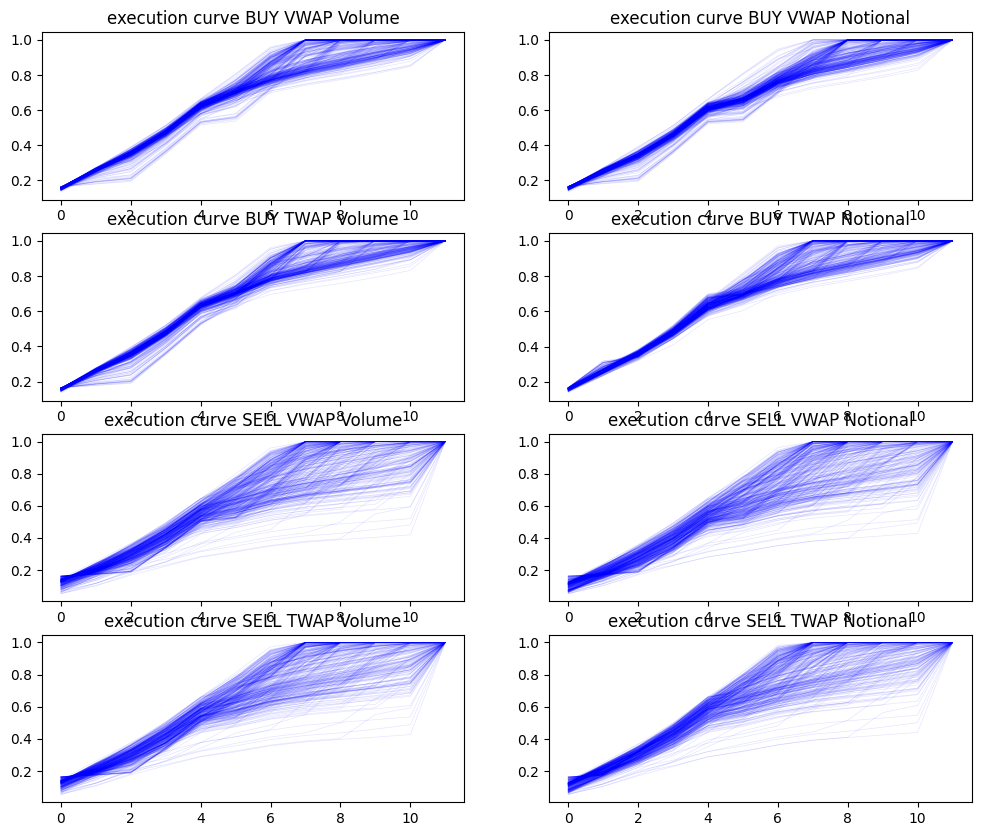

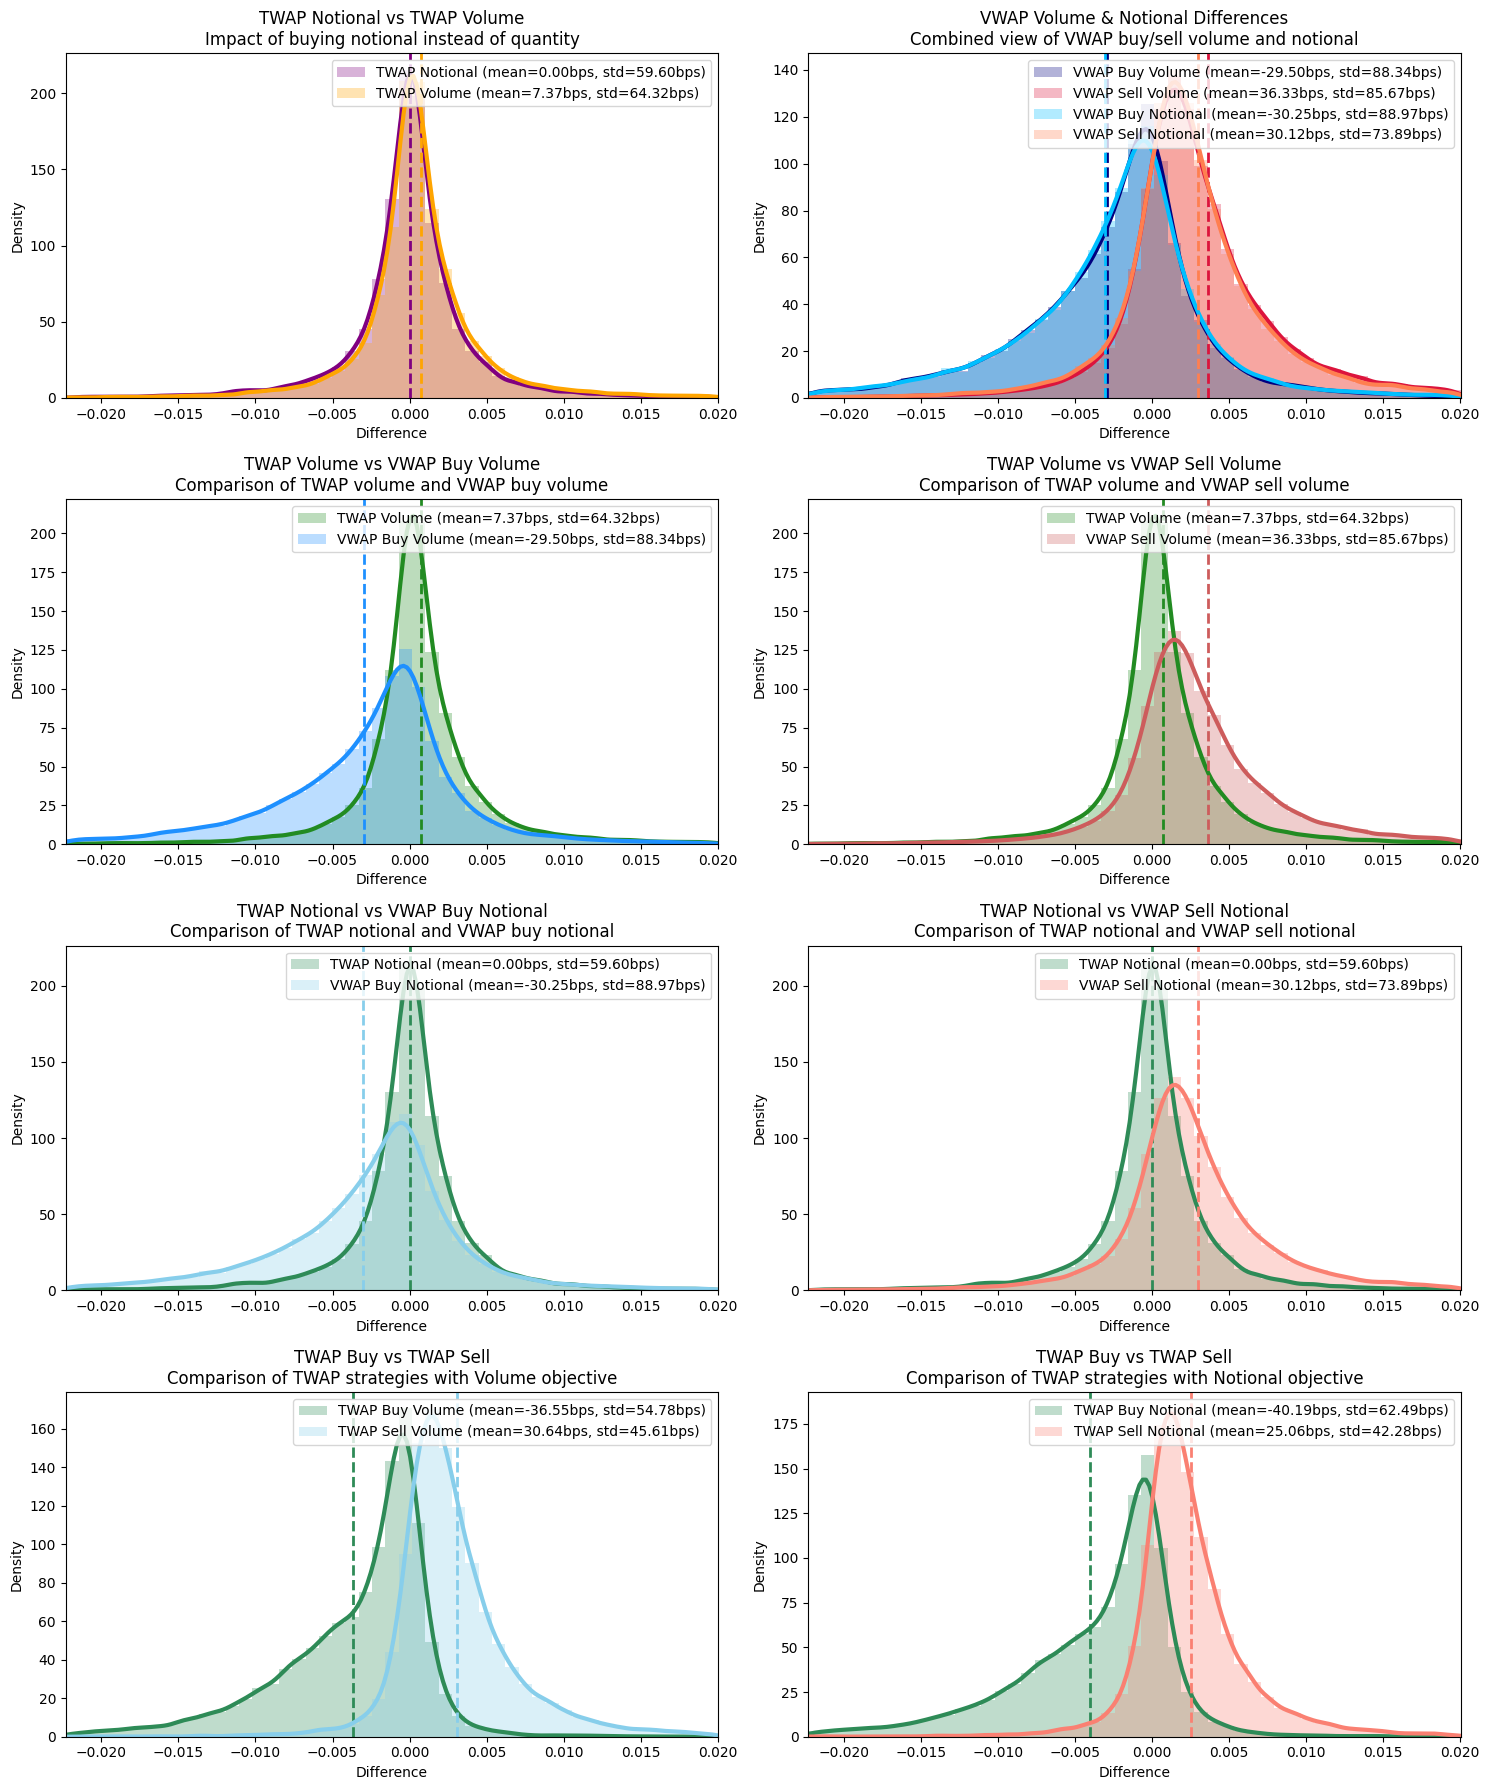

result using min_period=1


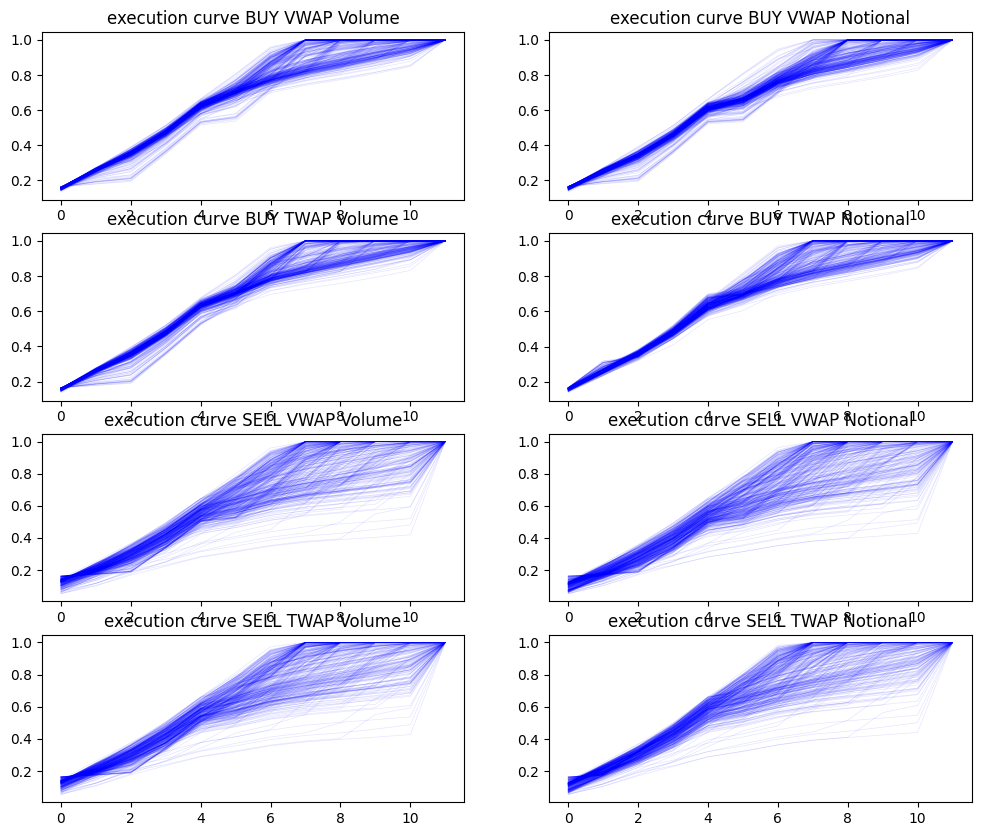

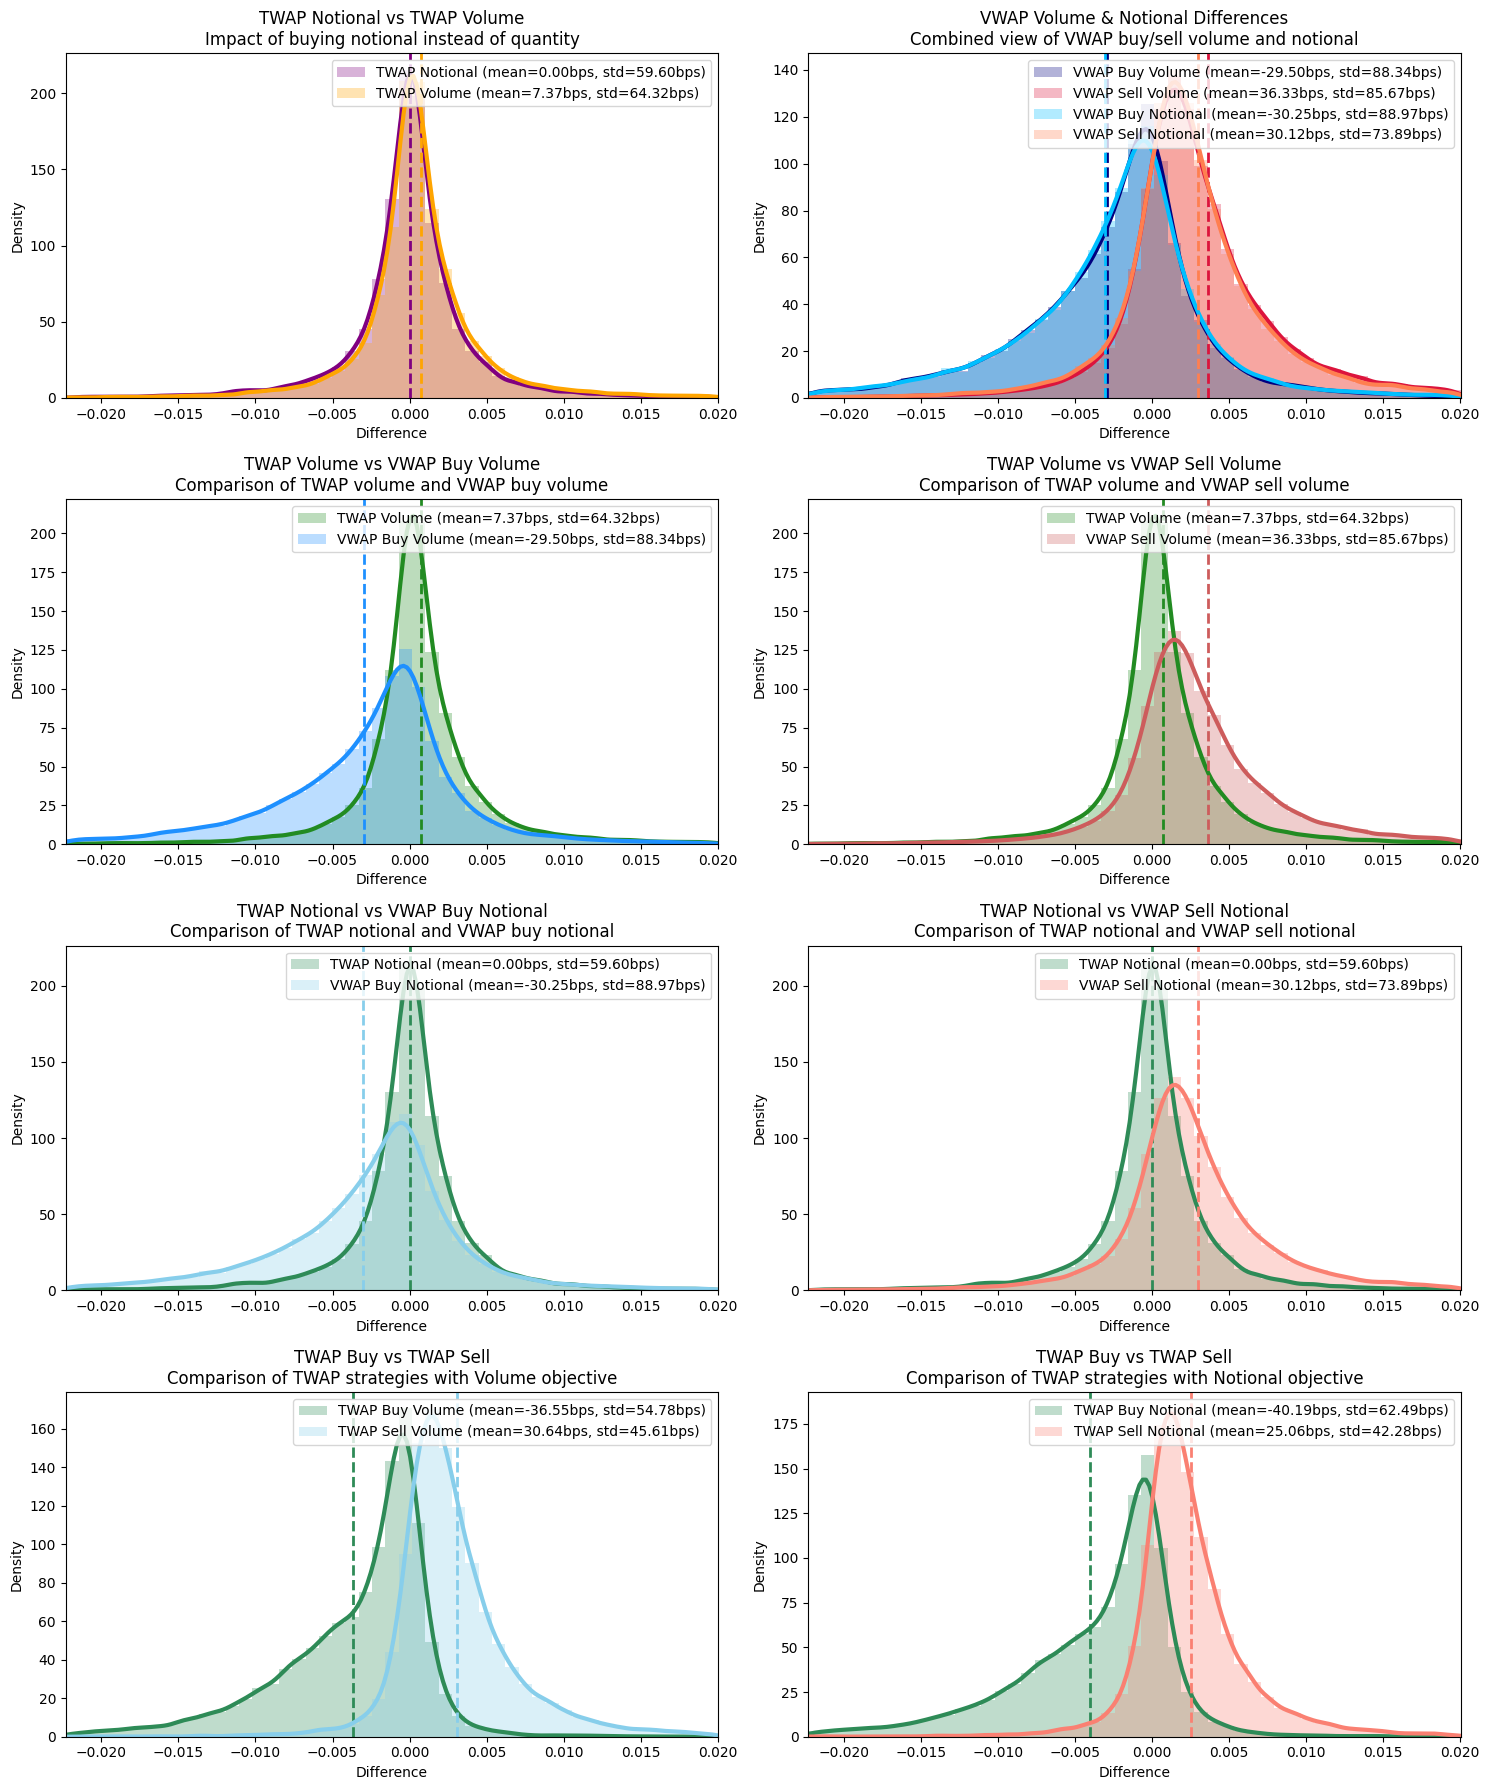

result using min_period=2


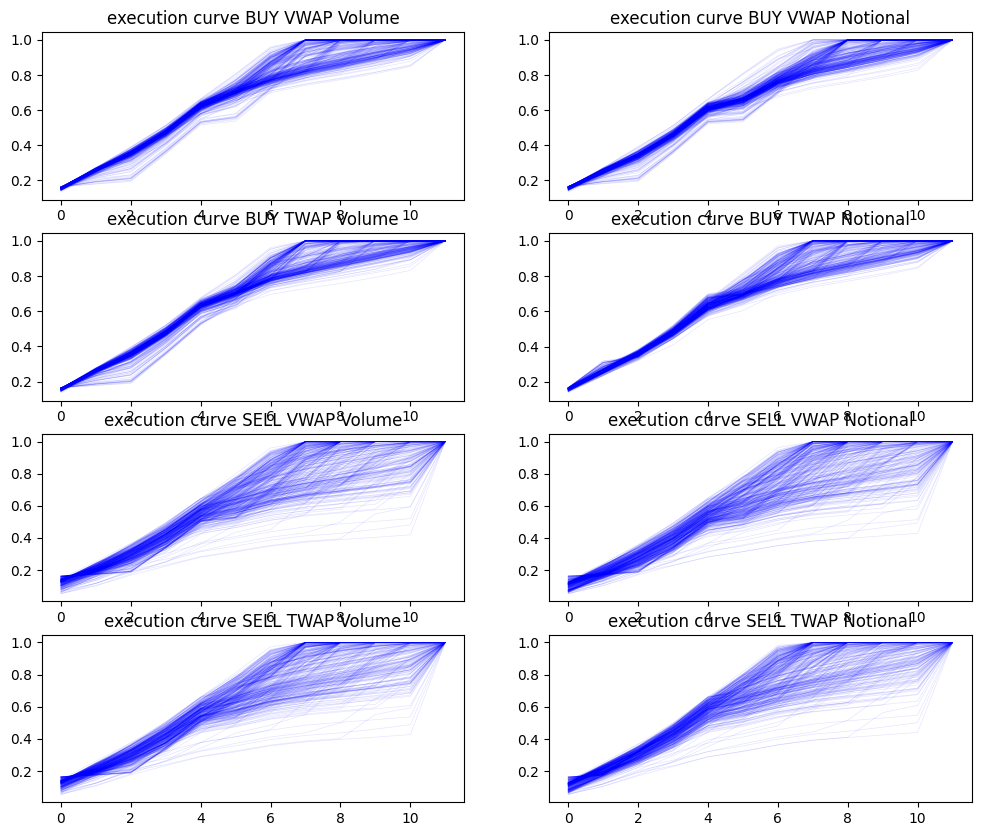

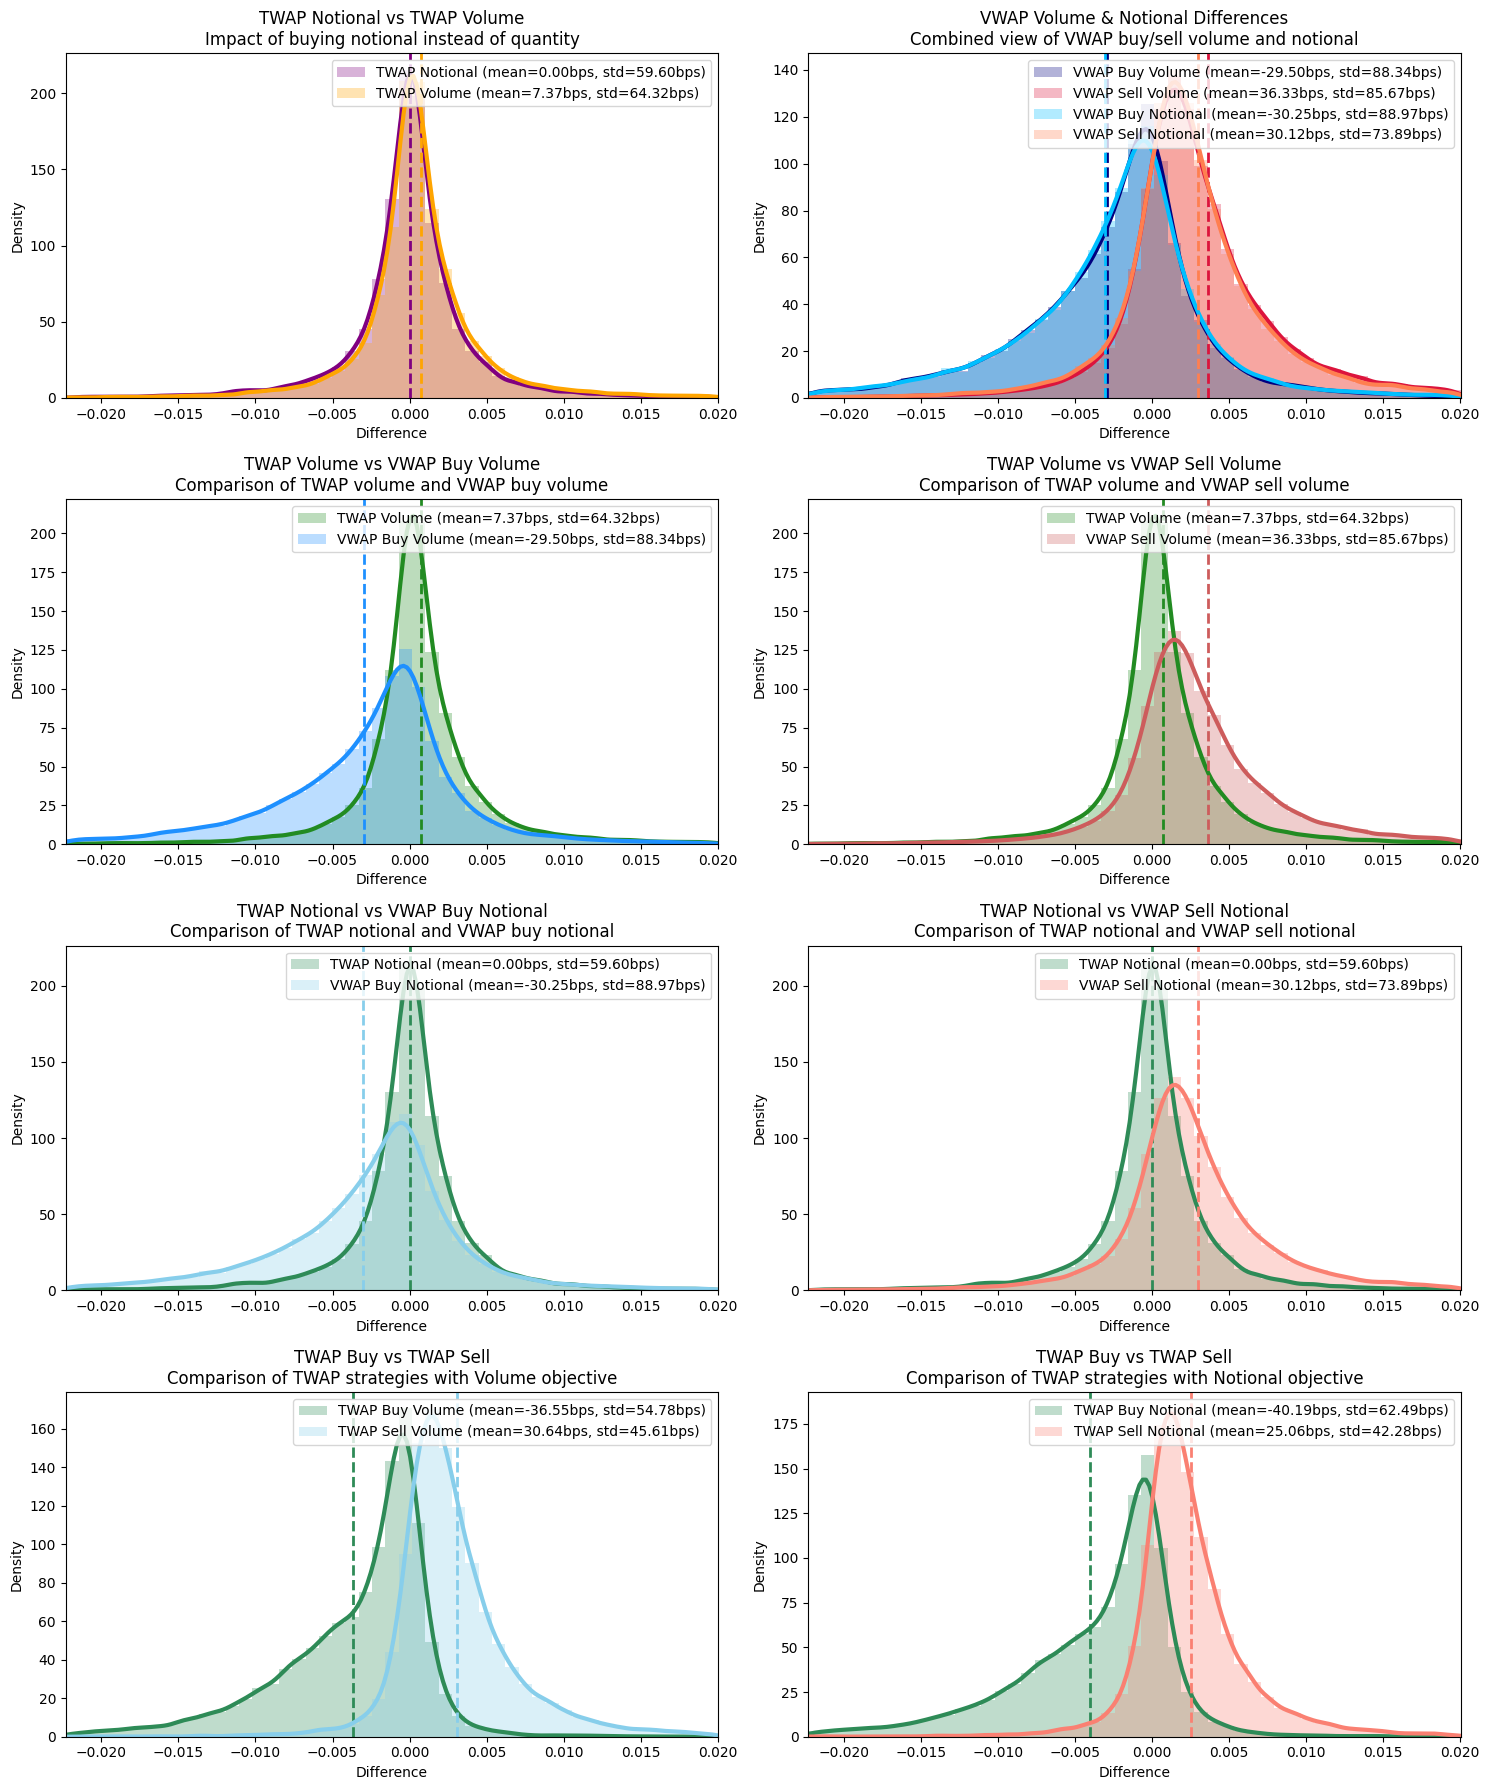

result using min_period=3


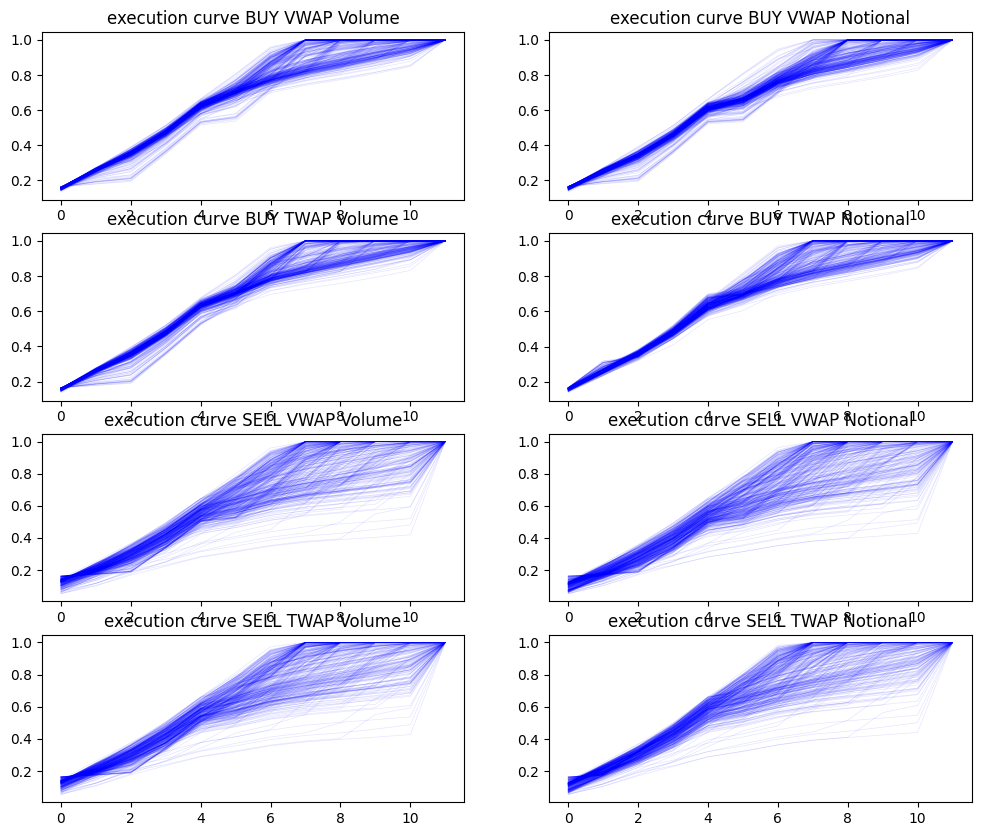

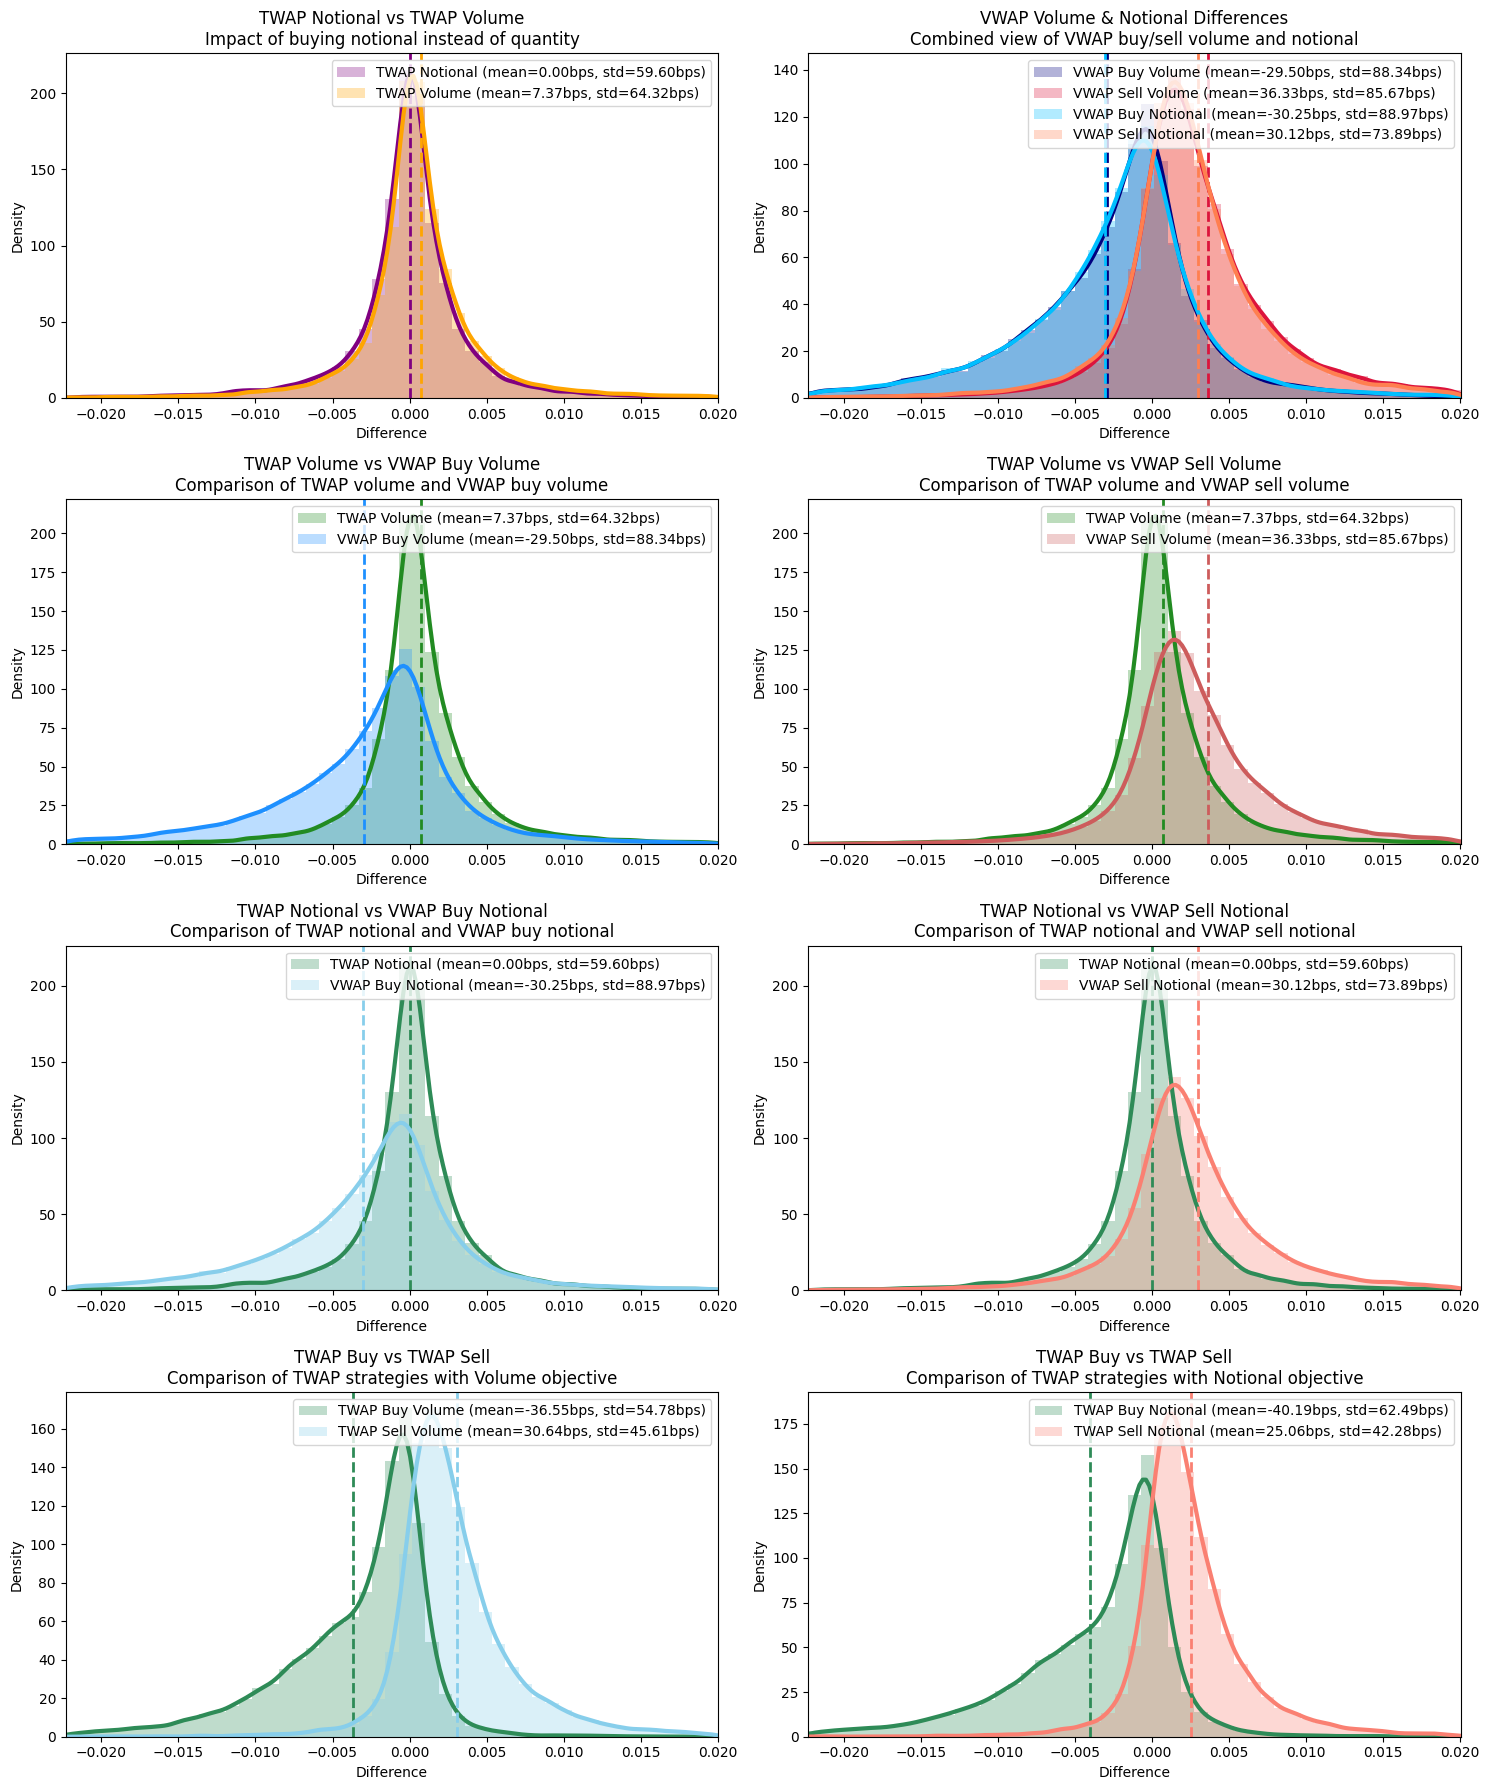

result using min_period=4


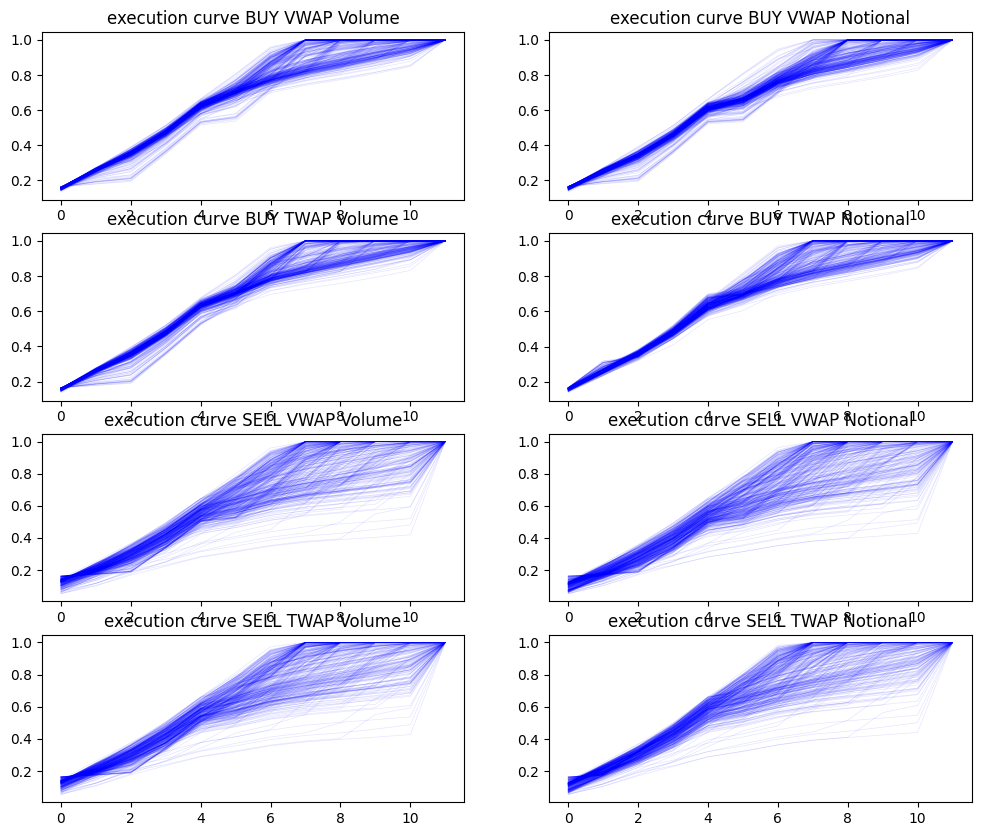

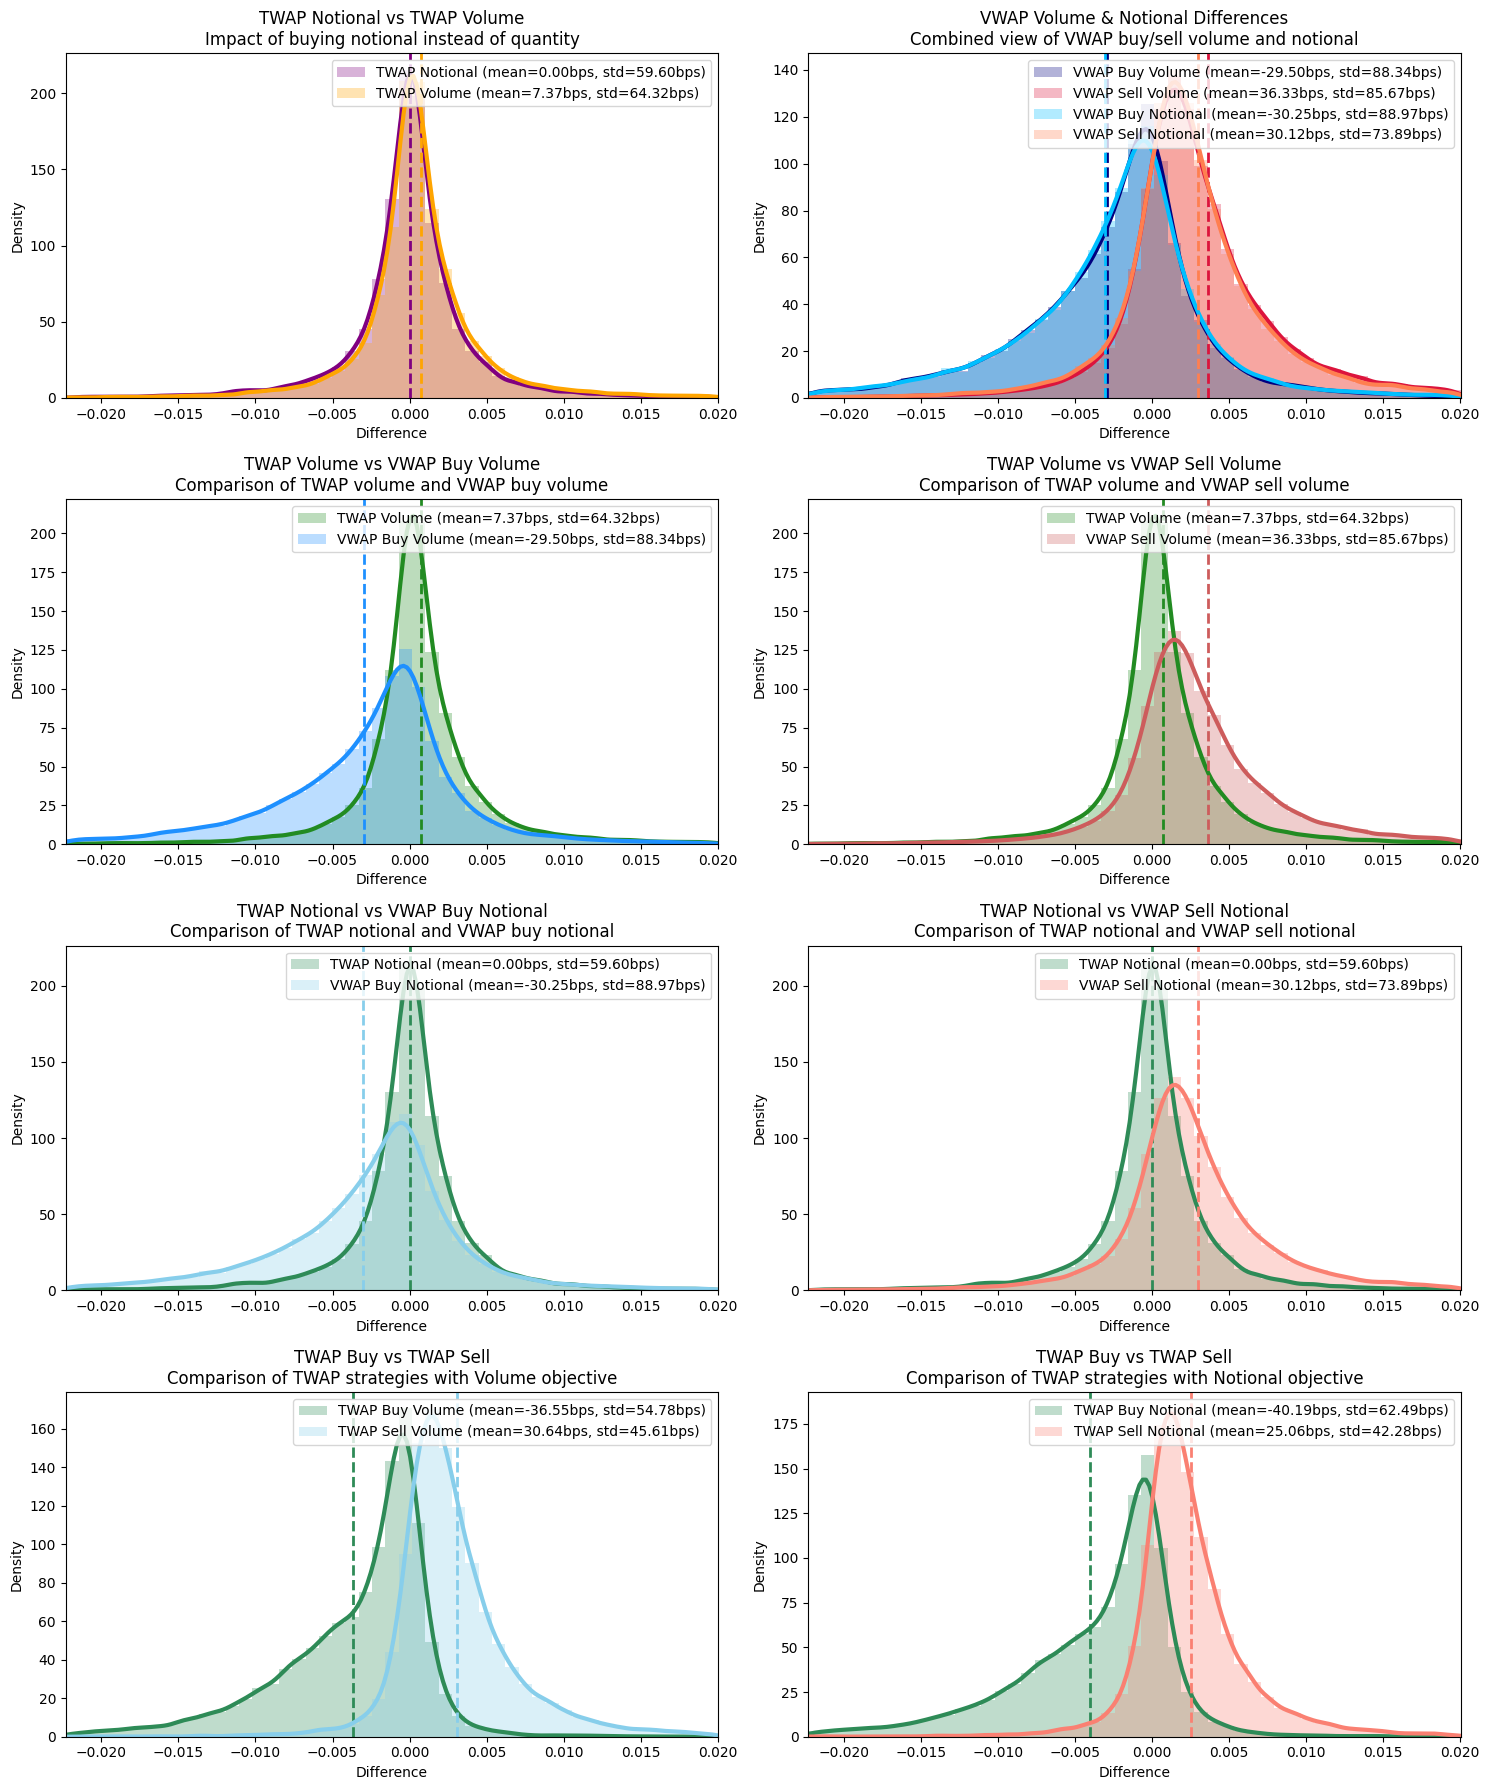

result using min_period=5


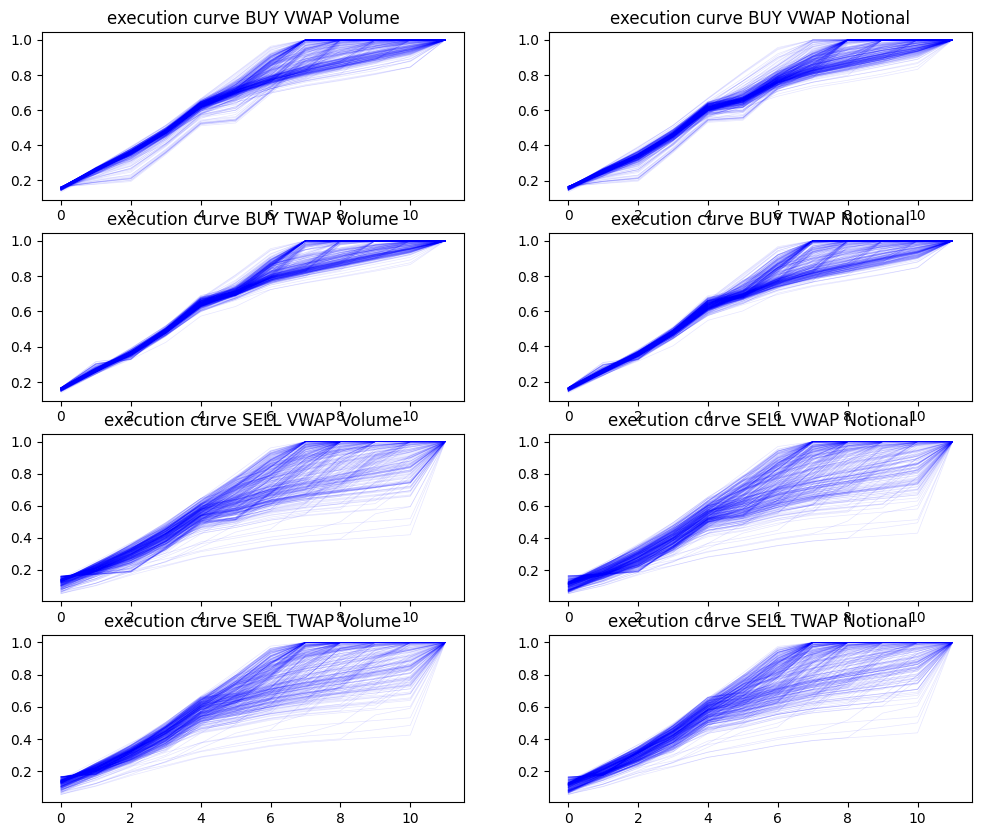

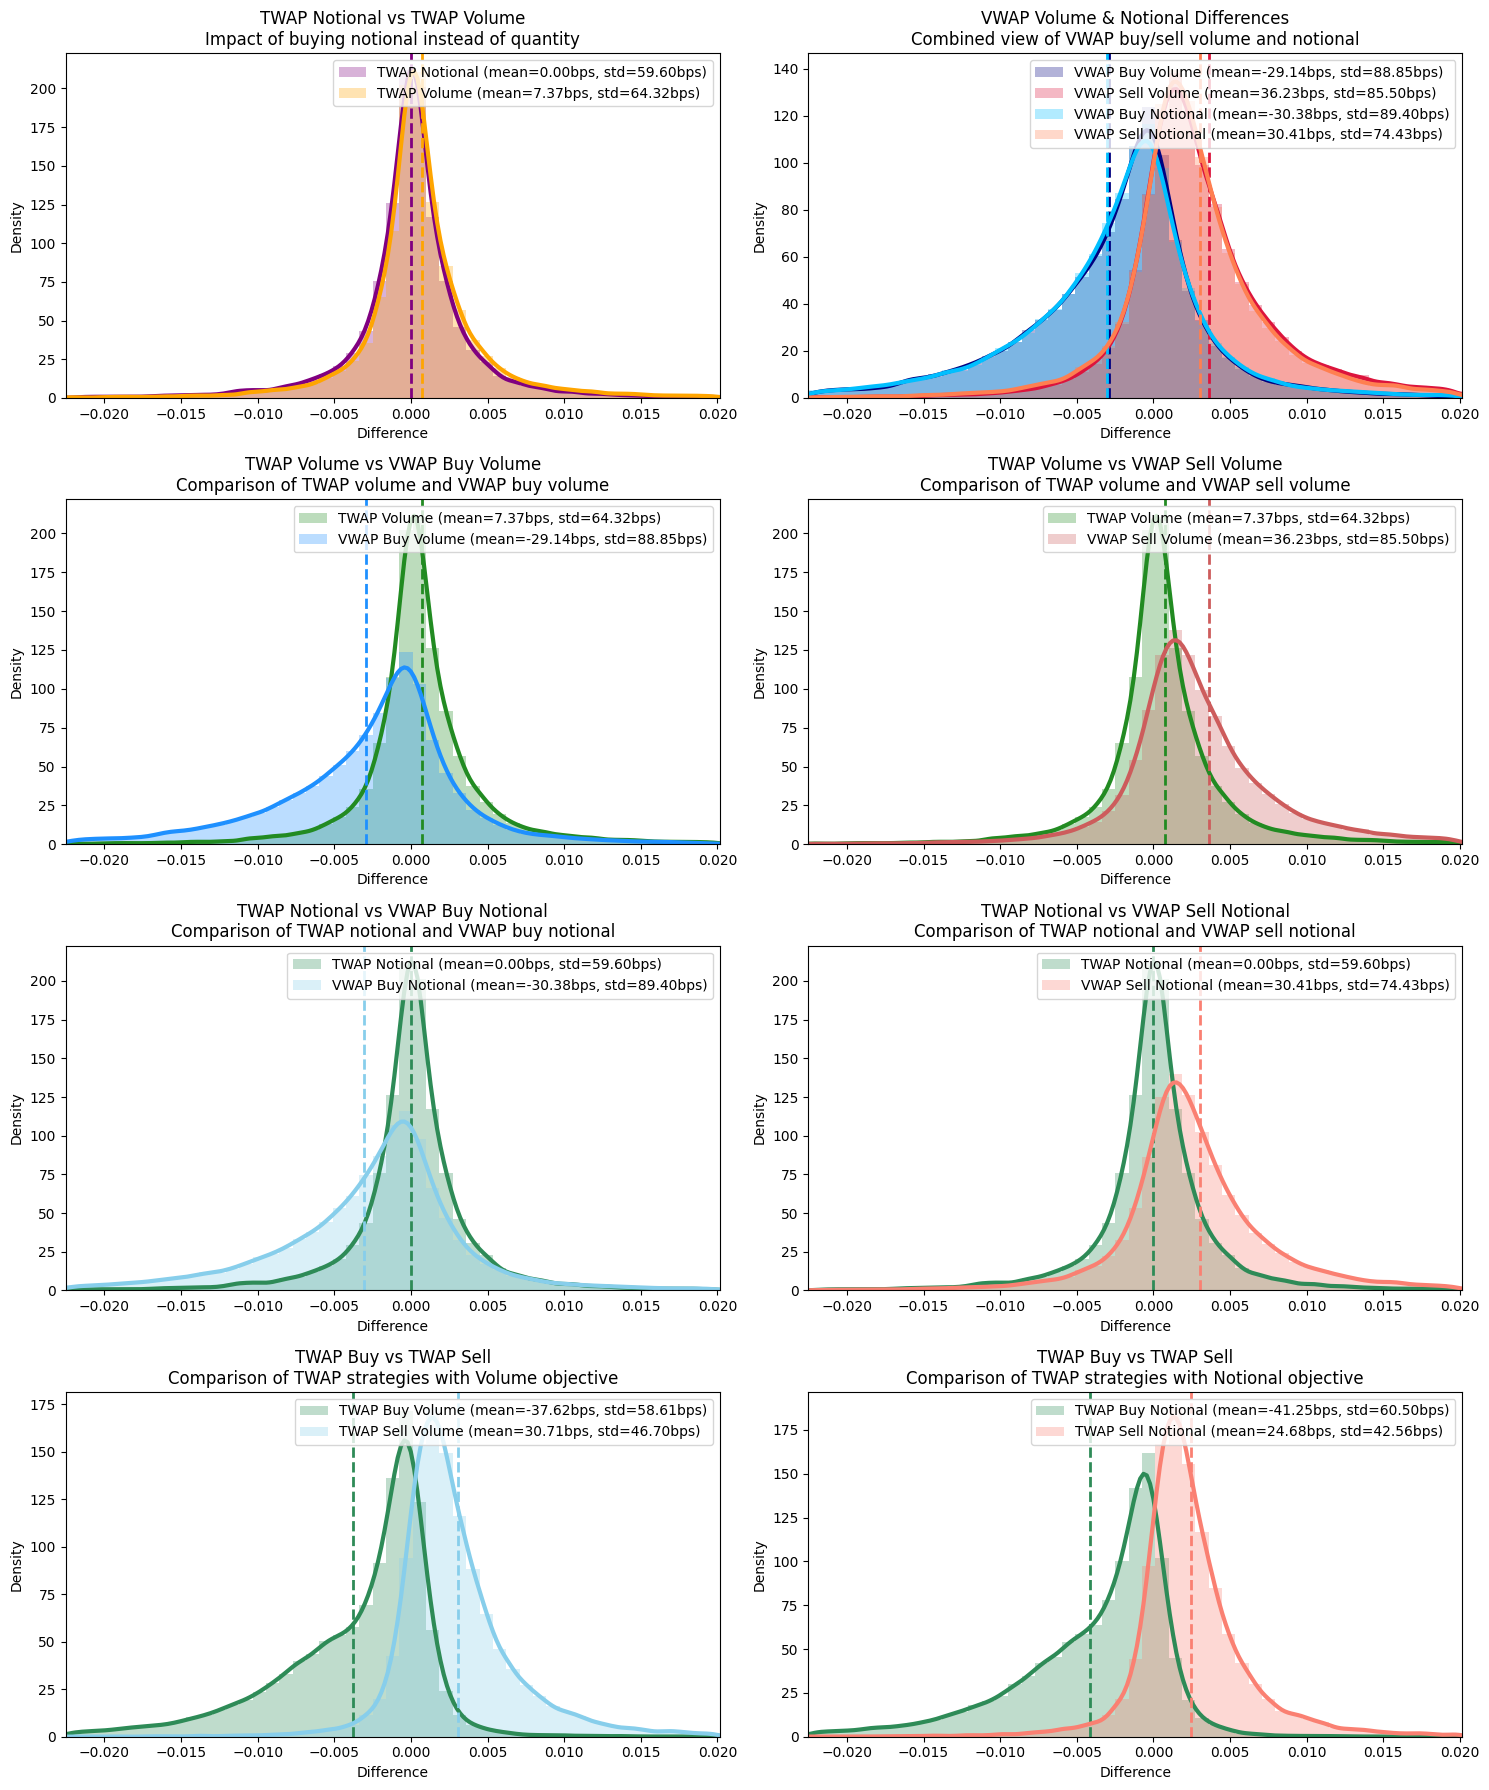

result using min_period=6


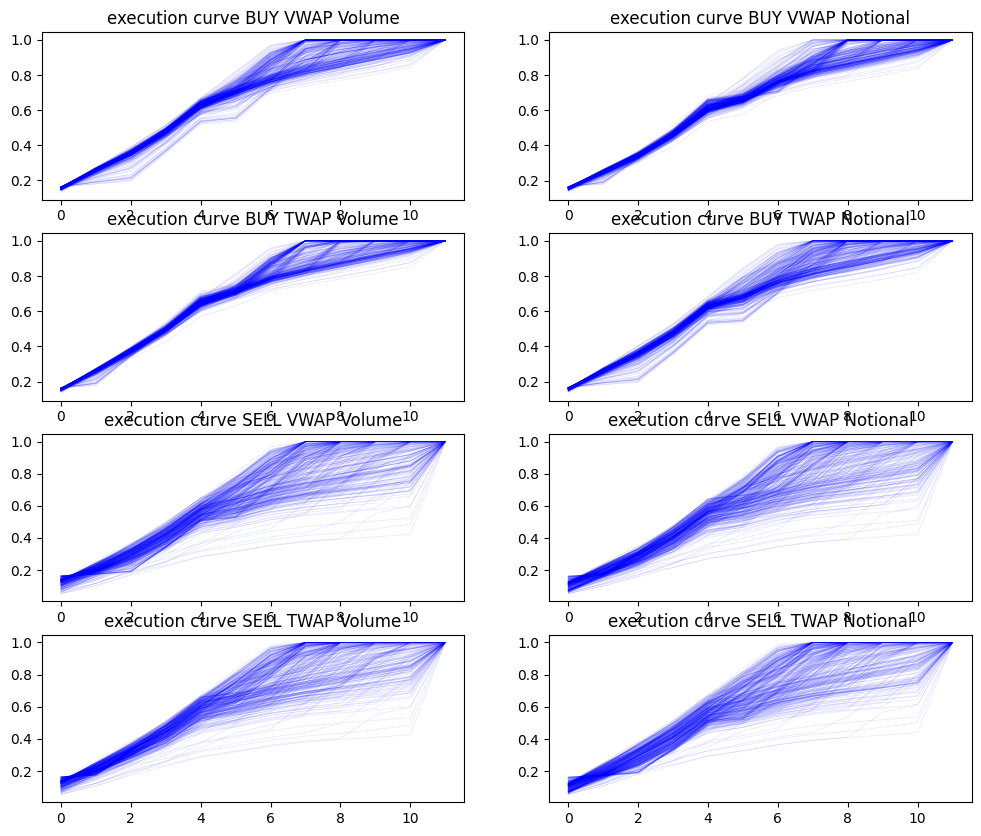

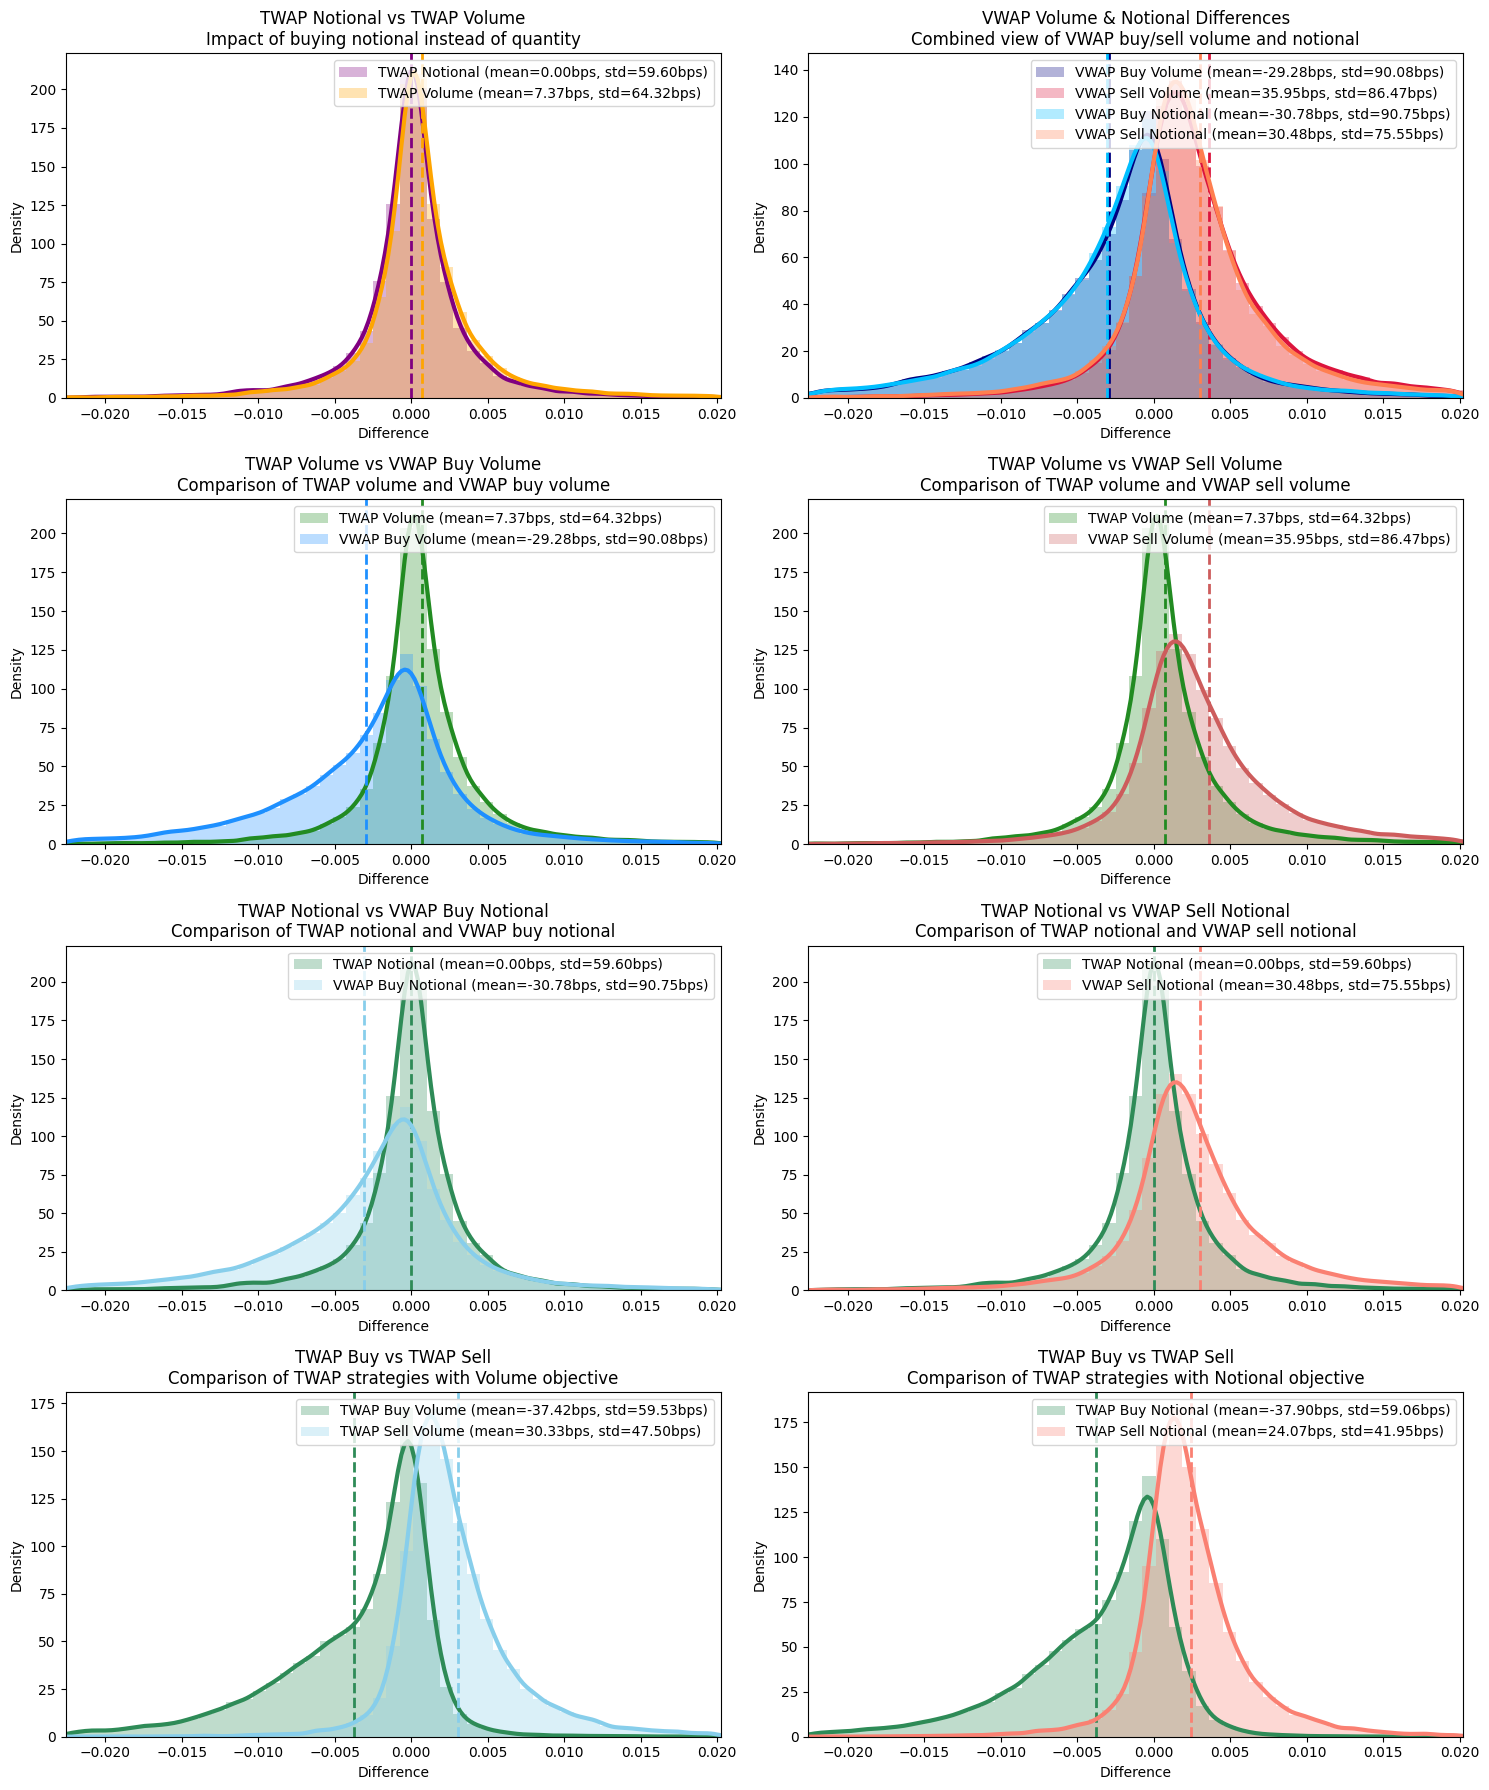

result using min_period=7


In [ ]:
augmented_X_test = add_config_to_X(full_X_test, 1 / n_ahead / n_ahead, 1.)
augmented_y_test = add_config_to_y(full_y_test)
print(f'Results with: min executed per period {1 / n_ahead / n_ahead} - max executed per period {1.}')
preds_to_graph(model, augmented_X_test, augmented_y_test, f'dow_results')

In [ ]:
tables = create_tables_from_predictions(model, augmented_X_test, augmented_y_test, name="dow_results_table")